### To note: Running this on different systems (i.e. local, SCW, server) will result in slight changes needing to the code

In [1]:
# Load libraries
import os
import numpy as np
import torch
import sys
import torchvision
import torchvision.transforms as T
import torchvision.models as models
from PIL import Image
from PIL import ImageEnhance
import matplotlib.pyplot as plt
import imagesize
import subprocess
sys.path
from IPython.core.debugger import set_trace
import scipy.ndimage
import matplotlib.patches as patches
# plt.rcParams['figure.figsize'] = [12,12]
# sys.path.append('/workspace/myFile/Mask_RCNN_Tutorial/')
from tqdm import tqdm
from torch import nn as nn
from torch import optim as optim
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import re
import time
import copy
import pylab
from torch.utils.tensorboard import SummaryWriter
from tempfile import TemporaryDirectory
import torch.backends.cudnn as cudnn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
import glob
# Rather than have a messy notebook with a load of functions we can store them in separate .py files and import them

cudnn.benchmark = True
plt.ion()   # interactive mode

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:

writer = SummaryWriter("Experiments/TENSORBOARD")    # This determines the tensorboard file name

In [3]:
class DNADataset(object):
    def __init__(self, root, transforms, labels, imDx = False):
        self.root, self.transforms, self.labels = root, transforms, labels
    
        # load all image files, sorting them to ensure they are aligned
        self.imgDir = glob.glob(root+"*/*.tiff")
        Damagednuclei= [x for x in self.imgDir if 'Damaged_nuclei_' in x]
        Undamagednuclei= [x for x in self.imgDir if "No_damage_nuclei" in x]
        np.random.shuffle(Undamagednuclei)
        Undamagednuclei=Undamagednuclei[:10000]
        self.imgDir= Damagednuclei+Undamagednuclei
        size80=[]
        for x in self.imgDir:
            img = Image.open(x) # Open image
            w,h=img.size
            if w<=80 and h<=80:
                size80.append(x)
        self.imgDir=size80              
        
        self.imgs = sorted(self.imgDir) # list of images

        

        
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
       
        # Transform images into tensors
        img = Image.open(img_path) # Open image
        w,h=img.size
        img = np.array(img) # Convert image into an array
        img = np.float32(np.divide(img, 2**16)) # Ensure all values are floats
        
        result=np.zeros((80,80), dtype=np.float32)
        x_center = (80 - w) // 2
        y_center = (80 - h) // 2 # copy img image into center of result image
        result[y_center:y_center+h, x_center:x_center+w] = img
        img = result
        
        targetlab=""
        if img_path.find('No_damage_nuclei') != -1:
            targetlab= 'Undamaged'
        if img_path.find('Damaged_nuclei_') != -1:
            targetlab= 'Damaged'  # Find labels corresponding to image
        target = self.labels.index(targetlab) # Get the label and assign to a value
        
        # Convert label to tensor
        #torch.to
        
        if self.transforms is not None:
            img = self.transforms(img)
#             #print('In the transforms')
        imNo = idx
        return img, target, imNo
        
    def __len__(self):
        return len(self.imgs)
 

In [4]:
imDr = "/workspace/myFile/Output/17052023/"  # Image patches directory

labels = ['Damaged', 'Undamaged']  # Your labels

In [5]:
# For data augmentation
def get_transform(train):
    transforms = []

    transforms.append(T.ToTensor())
    transforms.append(T.Normalize([0.0019368887995516483], [0.00672996630111016]))
    #transforms.append(T.RandomHorizontalFlip(0.5))
    
    if train:
        transforms.append(T.RandomHorizontalFlip(p=1))
        transforms.append(T.RandomVerticalFlip(p=1))
        transforms.append(T.RandomPerspective(p=1))
        transforms.append(T.RandomRotation(degrees=(-180,180)))
        transforms.append(T.RandomAutocontrast(p=1))
    
    return T.Compose(transforms)

In [6]:
def train_model(model, criterion, optimizer, scheduler, dataloaderTrain, dataloaderTest, num_epochs=25):
    since = time.time()
    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                    dataloaders = dataloaderTrain
                else:
                    model.eval()   # Set model to evaluate mode
                    dataloaders = dataloaderTest

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels, imNo in dataloaders:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)    # Loss
                    running_corrects += torch.sum(preds == labels.data) # Accuracy

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]    # Loss metric per epoch
                epoch_acc = running_corrects.double() / dataset_sizes[phase]    # Accuracy metric per epoch

                if phase == "train":    # This is the tensorboard code that writes accuracy and loss metrics
                    writer.add_scalar("Train/Accuracy", epoch_acc, epoch)
                    writer.add_scalar("Train/Loss", epoch_loss, epoch)
                else:
                    writer.add_scalar("Validation/Accuracy", epoch_acc, epoch)
                    writer.add_scalar("Validation/Loss", epoch_loss, epoch)

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc: 
                    # This compares validation accuracy to previous bests and adjusts model weights accordingly
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since  # Nice way to measure training time but info also stored (indirectly) by tensorboard
        print(
            f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        labels= labels.cpu().numpy()
        preds=preds.cpu().numpy()
        con_mat = confusion_matrix(labels, preds)   # Confusion matrix compares true class with predicted class
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    writer.close()
    return model, con_mat   # We want to return the model because its the model, also confusion matrix for later analysis


In [7]:
# This is your RESNET
# Initialize CNN with kaiming
def init_cnn(m):
    # Set the weights of the RESNET
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)


# noop function for returning nothing
def noop(x): return x
# activation function(RELU)
act_fn = nn.ReLU(inplace=True)

# Flatten
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

# Make a convolution
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

# Create a convuolutional layer with convolution and batch norm
def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf) # get a 2d batch norm from Pytorhc
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn) # add in the activation function if act is true
    return nn.Sequential(*layers)


# Resblock
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride = 1):
        super().__init__()
        # ni - number of inputs channels, nf - number of filters
        # nh - number of filters in first conv
        # expansion is 1 for resnet 18, 34 and 4 for larger networks
        nf, ni = nh*expansion, ni*expansion
        layers = [conv_layer(ni, nh, 3, stride = stride), # for resnet < 34 2 convs per resblock
                 conv_layer(nh, nf, 3, zero_bn = True, act = False)
                 ] if expansion == 1 else [ # for RESNET > 34 then 3 convs per block with bottleneck
                            conv_layer(ni, nh, 1),
                            conv_layer(nh, nh, 3, stride = stride),
                            conv_layer(nh, nf, 1, zero_bn = True, act = False)
        ]
        self.convs = nn.Sequential(*layers) # Creates the conv layers
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act = False) # id convolution ()
        self.pool = noop if stride== 1 else nn.AvgPool2d(2, ceil_mode = True) # average pool on 
        
    def forward(self, x): 
        # Forward function adds the convolution part to the id part 
        #return act_fn(self.convs(x)) + self.idconv(self.pool(x))
        return act_fn(self.convs(x) + self.idconv(self.pool(x)))

# XResnet
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1000):
        nfs = [c_in, (c_in + 1)*8, 64, 64] # number of filters in stem layer (c_in is number of image channels)
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
        *stem,
        nn.MaxPool2d(kernel_size=3, stride = 2, padding = 1), # then a max pooling layer
        *res_layers,
        nn.AdaptiveAvgPool2d(1), Flatten(), 
        nn.Linear(nfs[-1]*expansion, c_out)
        )
        init_cnn(res)
        return res
        
    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride): # returns a resblock
        return nn.Sequential(
        *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
         for i in range(n_blocks)])

In [8]:

def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
#model = xresnet18(c_in = 1, c_out = 2)
#model = xresnet34(c_in = 1, c_out = 2)
model = xresnet50(c_in = 1, c_out = 2)
model = model.to(device)

# Label smoothing cross entropy
import torch.nn.functional as F


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction=='mean' else loss.sum() if reduction=='sum' else loss

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

In [9]:
# Helper functions that shows the image, true class, predicted class and degree of prediction

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            labels[preds[idx]],
            probs[idx] * 100.0,
            labels[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

def matplotlib_imshow(img, one_channel=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [10]:
def confusion_matrix_calc(data_loader_test, classes, model_ft):       
        y_pred = []
        y_true = []
        for inputs, labels, imNo in data_loader_test:
                inputs = inputs.to(device)
                labels = labels.to(device)
                output = model_ft(inputs) # Feed Network

                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction
                
                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

        # constant for classes
        # classes = ('Alive', 'Dead')

        # Build confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred)
        return cf_matrix


In [11]:
torch.manual_seed(10)
imIdx = torch.randperm(101106).tolist()

## Create dataset
dataSetTrain = DNADataset(imDr, get_transform(train = True), labels, imDx=imIdx)
dataSetTest = DNADataset(imDr, get_transform(train = False), labels, imDx=imIdx)

# ## Create dataloaders
# Get subset
torch.manual_seed(10)
indices = torch.randperm(len(dataSetTrain)).tolist()

noTrain = int(len(dataSetTrain)*0.7)

dataset_train = torch.utils.data.Subset(dataSetTrain, indices[-noTrain:])
dataset_test = torch.utils.data.Subset(dataSetTest, indices[:-noTrain])
#len(indices), len(indices[:-50]), len(indices[-50:]), 50/191, type(dataset_test)

dataset_sizes = {'train': len(dataset_train), 'val': len(dataset_test)}

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=20, shuffle=True, num_workers=0)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=20, shuffle=False, num_workers=0)


# Collate function (gathers together the outputs)
# def collate_fn(batch):
#     return tuple(zip(*batch))

len(indices[-noTrain:]), dataset_sizes
#dataset_test[0][1], dataset_test[3][1], dataset_test[-1][1], dataSetTrain.imgs

(13906, {'train': 13906, 'val': 5961})

In [12]:

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), weight_decay=1e-2) # standard ADAM optimiser

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft, con_mat = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       data_loader_train,data_loader_test,num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6769 Acc: 0.5971
val Loss: 2.5069 Acc: 0.4991

Epoch 1/19
----------
train Loss: 0.6500 Acc: 0.6245
val Loss: 6.3796 Acc: 0.4997

Epoch 2/19
----------
train Loss: 0.6368 Acc: 0.6373
val Loss: 1.3829 Acc: 0.5004

Epoch 3/19
----------
train Loss: 0.6098 Acc: 0.6750
val Loss: 0.9584 Acc: 0.4956

Epoch 4/19
----------
train Loss: 0.5856 Acc: 0.6991
val Loss: 1.7886 Acc: 0.4959

Epoch 5/19
----------
train Loss: 0.5704 Acc: 0.7146
val Loss: 1.5576 Acc: 0.4999

Epoch 6/19
----------
train Loss: 0.5609 Acc: 0.7165
val Loss: 1.4866 Acc: 0.5120

Epoch 7/19
----------
train Loss: 0.5348 Acc: 0.7346
val Loss: 1.5776 Acc: 0.4836

Epoch 8/19
----------
train Loss: 0.5261 Acc: 0.7435
val Loss: 1.7666 Acc: 0.4932

Epoch 9/19
----------
train Loss: 0.5241 Acc: 0.7435
val Loss: 1.8040 Acc: 0.5132

Epoch 10/19
----------
train Loss: 0.5217 Acc: 0.7505
val Loss: 1.8285 Acc: 0.5115

Epoch 11/19
----------
train Loss: 0.5188 Acc: 0.7495
val Loss: 1.8354 Acc: 0.5068

Ep

In [14]:
cf_matrix = confusion_matrix_calc(data_loader_test, labels, model_ft)

[Text(0.5, 42.0, 'Predicted Result'), Text(87.0, 0.5, 'True Result')]

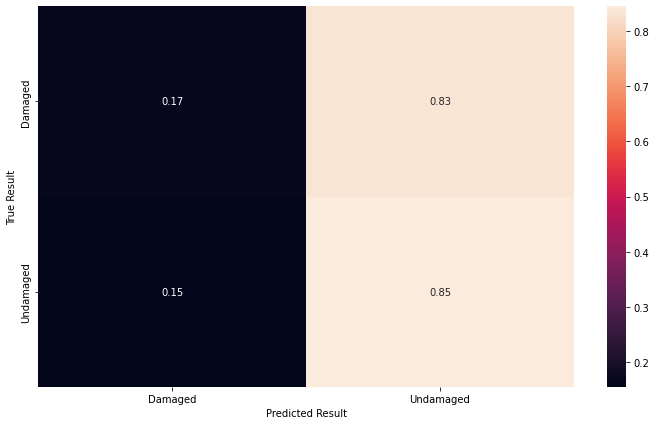

In [15]:
df_cm_ratio = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in labels],
                     columns=[i for i in labels])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm_ratio, annot=True).set(xlabel='Predicted Result', ylabel='True Result')
# plt.save("Confusion_matrix_ratio.png")

[Text(0.5, 42.0, 'Predicted Result'), Text(87.0, 0.5, 'True Result')]

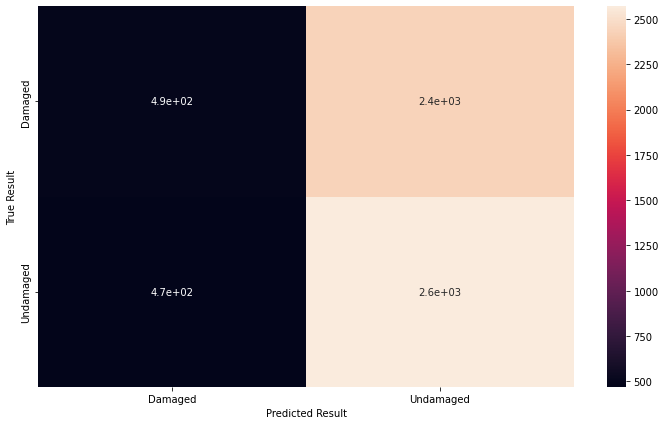

In [16]:
df_cm_raw = pd.DataFrame(cf_matrix, index=[i for i in labels],
                     columns=[i for i in labels])
plt.figure(figsize=(12, 7))
sn.heatmap(df_cm_raw, annot=True).set(xlabel='Predicted Result', ylabel='True Result')
# plt.save("Confusion_matrix_raw.png")

In [17]:
cf_matrix

array([[ 489, 2433],
       [ 469, 2570]])

In [18]:
len(data_loader_test) 
#for inputs in data_loader_test:

for inputs in data_loader_train:
    print(inputs)

[tensor([[[[0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          ...,
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599]]],


        [[[0.0688, 0.0688, 0.0688,  ..., 0.0688, 0.0688, 0.0688],
          [0.0688, 0.0688, 0.0688,  ..., 0.0688, 0.0688, 0.0688],
          [0.0688, 0.0688, 0.0688,  ..., 0.0688, 0.0688, 0.0688],
          ...,
          [0.0688, 0.0688, 0.0688,  ..., 0.0688, 0.0688, 0.0688],
          [0.0688, 0.0688, 0.0688,  ..., 0.0688, 0.0688, 0.0688],
          [0.0688, 0.0688, 0.0688,  ..., 0.0688, 0.0688, 0.0688]]],


        [[[0.0794, 0.0794, 0.0794,  ..., 0.0794, 0.0794, 0.0794],
          [0.0794, 0.0794, 0.0794,  ..., 0.0794, 0.0794, 0.0794],
          [0.0794, 0.0794, 0.0794,  .

[tensor([[[[0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          ...,
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960]]],


        [[[0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          ...,
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759]]],


        [[[0.0341, 0.0341, 0.0341,  ..., 0.0341, 0.0341, 0.0341],
          [0.0341, 0.0341, 0.0341,  ..., 0.0341, 0.0341, 0.0341],
          [0.0341, 0.0341, 0.0341,  .

[tensor([[[[0.0971, 0.0971, 0.0971,  ..., 0.0971, 0.0971, 0.0971],
          [0.0971, 0.0971, 0.0971,  ..., 0.0971, 0.0971, 0.0971],
          [0.0971, 0.0971, 0.0971,  ..., 0.0971, 0.0971, 0.0971],
          ...,
          [0.0971, 0.0971, 0.0971,  ..., 0.0971, 0.0971, 0.0971],
          [0.0971, 0.0971, 0.0971,  ..., 0.0971, 0.0971, 0.0971],
          [0.0971, 0.0971, 0.0971,  ..., 0.0971, 0.0971, 0.0971]]],


        [[[0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          ...,
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820]]],


        [[[0.0643, 0.0643, 0.0643,  ..., 0.0643, 0.0643, 0.0643],
          [0.0643, 0.0643, 0.0643,  ..., 0.0643, 0.0643, 0.0643],
          [0.0643, 0.0643, 0.0643,  .

[tensor([[[[0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          ...,
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558]]],


        [[[0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          ...,
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606]]],


        [[[0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          [0.0799, 0.0799, 0.0799,  .

[tensor([[[[7.5918e-02, 7.5918e-02, 7.5918e-02,  ..., 7.5918e-02,
           7.5918e-02, 7.5918e-02],
          [7.5918e-02, 7.5918e-02, 7.5918e-02,  ..., 7.5918e-02,
           7.5918e-02, 7.5918e-02],
          [7.5918e-02, 7.5918e-02, 7.5918e-02,  ..., 7.5918e-02,
           7.5918e-02, 7.5918e-02],
          ...,
          [7.5918e-02, 7.5918e-02, 7.5918e-02,  ..., 7.5918e-02,
           7.5918e-02, 7.5918e-02],
          [7.5918e-02, 7.5918e-02, 7.5918e-02,  ..., 7.5918e-02,
           7.5918e-02, 7.5918e-02],
          [7.5918e-02, 7.5918e-02, 7.5918e-02,  ..., 7.5918e-02,
           7.5918e-02, 7.5918e-02]]],


        [[[6.1067e-02, 6.1067e-02, 6.1067e-02,  ..., 6.1067e-02,
           6.1067e-02, 6.1067e-02],
          [6.1067e-02, 6.1067e-02, 6.1067e-02,  ..., 6.1067e-02,
           6.1067e-02, 6.1067e-02],
          [6.1067e-02, 6.1067e-02, 6.1067e-02,  ..., 6.1067e-02,
           6.1067e-02, 6.1067e-02],
          ...,
          [6.1067e-02, 6.1067e-02, 6.1067e-02,  ..., 6.1

[tensor([[[[0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          ...,
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730]]],


        [[[0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          ...,
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788]]],


        [[[0.1676, 0.1676, 0.1676,  ..., 0.1676, 0.1676, 0.1676],
          [0.1676, 0.1676, 0.1676,  ..., 0.1676, 0.1676, 0.1676],
          [0.1676, 0.1676, 0.1676,  .

[tensor([[[[0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          ...,
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561]]],


        [[[0.0751, 0.0751, 0.0751,  ..., 0.0751, 0.0751, 0.0751],
          [0.0751, 0.0751, 0.0751,  ..., 0.0751, 0.0751, 0.0751],
          [0.0751, 0.0751, 0.0751,  ..., 0.0751, 0.0751, 0.0751],
          ...,
          [0.0751, 0.0751, 0.0751,  ..., 0.0751, 0.0751, 0.0751],
          [0.0751, 0.0751, 0.0751,  ..., 0.0751, 0.0751, 0.0751],
          [0.0751, 0.0751, 0.0751,  ..., 0.0751, 0.0751, 0.0751]]],


        [[[0.0696, 0.0696, 0.0696,  ..., 0.0696, 0.0696, 0.0696],
          [0.0696, 0.0696, 0.0696,  ..., 0.0696, 0.0696, 0.0696],
          [0.0696, 0.0696, 0.0696,  .

[tensor([[[[0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          ...,
          [0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594]]],


        [[[0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          ...,
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568]]],


        [[[0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532],
          [0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532],
          [0.0532, 0.0532, 0.0532,  .

[tensor([[[[0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          ...,
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565]]],


        [[[0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          ...,
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630]]],


        [[[0.1443, 0.1443, 0.1443,  ..., 0.1443, 0.1443, 0.1443],
          [0.1443, 0.1443, 0.1443,  ..., 0.1443, 0.1443, 0.1443],
          [0.1443, 0.1443, 0.1443,  .

[tensor([[[[0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          ...,
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796]]],


        [[[0.0612, 0.0612, 0.0612,  ..., 0.0612, 0.0612, 0.0612],
          [0.0612, 0.0612, 0.0612,  ..., 0.0612, 0.0612, 0.0612],
          [0.0612, 0.0612, 0.0612,  ..., 0.0612, 0.0612, 0.0612],
          ...,
          [0.0612, 0.0612, 0.0612,  ..., 0.0612, 0.0612, 0.0612],
          [0.0612, 0.0612, 0.0612,  ..., 0.0612, 0.0612, 0.0612],
          [0.0612, 0.0612, 0.0612,  ..., 0.0612, 0.0612, 0.0612]]],


        [[[0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  ..., 0.0632, 0.0632, 0.0632],
          [0.0632, 0.0632, 0.0632,  .

[tensor([[[[0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          ...,
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576]]],


        [[[0.0460, 0.0460, 0.0460,  ..., 0.0460, 0.0460, 0.0460],
          [0.0460, 0.0460, 0.0460,  ..., 0.0460, 0.0460, 0.0460],
          [0.0460, 0.0460, 0.0460,  ..., 0.0460, 0.0460, 0.0460],
          ...,
          [0.0460, 0.0460, 0.0460,  ..., 0.0460, 0.0460, 0.0460],
          [0.0460, 0.0460, 0.0460,  ..., 0.0460, 0.0460, 0.0460],
          [0.0460, 0.0460, 0.0460,  ..., 0.0460, 0.0460, 0.0460]]],


        [[[0.0655, 0.0655, 0.0655,  ..., 0.0655, 0.0655, 0.0655],
          [0.0655, 0.0655, 0.0655,  ..., 0.0655, 0.0655, 0.0655],
          [0.0655, 0.0655, 0.0655,  .

[tensor([[[[0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          ...,
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636],
          [0.0636, 0.0636, 0.0636,  ..., 0.0636, 0.0636, 0.0636]]],


        [[[0.0351, 0.0351, 0.0351,  ..., 0.0351, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0351,  ..., 0.0351, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0351,  ..., 0.0351, 0.0351, 0.0351],
          ...,
          [0.0351, 0.0351, 0.0351,  ..., 0.0351, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0351,  ..., 0.0351, 0.0351, 0.0351],
          [0.0351, 0.0351, 0.0351,  ..., 0.0351, 0.0351, 0.0351]]],


        [[[0.0748, 0.0748, 0.0748,  ..., 0.0748, 0.0748, 0.0748],
          [0.0748, 0.0748, 0.0748,  ..., 0.0748, 0.0748, 0.0748],
          [0.0748, 0.0748, 0.0748,  .

[tensor([[[[0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          ...,
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601]]],


        [[[0.1095, 0.1095, 0.1095,  ..., 0.1095, 0.1095, 0.1095],
          [0.1095, 0.1095, 0.1095,  ..., 0.1095, 0.1095, 0.1095],
          [0.1095, 0.1095, 0.1095,  ..., 0.1095, 0.1095, 0.1095],
          ...,
          [0.1095, 0.1095, 0.1095,  ..., 0.1095, 0.1095, 0.1095],
          [0.1095, 0.1095, 0.1095,  ..., 0.1095, 0.1095, 0.1095],
          [0.1095, 0.1095, 0.1095,  ..., 0.1095, 0.1095, 0.1095]]],


        [[[0.0843, 0.0843, 0.0843,  ..., 0.0843, 0.0843, 0.0843],
          [0.0843, 0.0843, 0.0843,  ..., 0.0843, 0.0843, 0.0843],
          [0.0843, 0.0843, 0.0843,  .

[tensor([[[[0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          ...,
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389]]],


        [[[0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          ...,
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125],
          [0.1125, 0.1125, 0.1125,  ..., 0.1125, 0.1125, 0.1125]]],


        [[[0.0489, 0.0489, 0.0489,  ..., 0.0489, 0.0489, 0.0489],
          [0.0489, 0.0489, 0.0489,  ..., 0.0489, 0.0489, 0.0489],
          [0.0489, 0.0489, 0.0489,  .

[tensor([[[[0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          ...,
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369]]],


        [[[0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          ...,
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553]]],


        [[[0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  .

[tensor([[[[0.0903, 0.0903, 0.0903,  ..., 0.0903, 0.0903, 0.0903],
          [0.0903, 0.0903, 0.0903,  ..., 0.0903, 0.0903, 0.0903],
          [0.0903, 0.0903, 0.0903,  ..., 0.0903, 0.0903, 0.0903],
          ...,
          [0.0903, 0.0903, 0.0903,  ..., 0.0903, 0.0903, 0.0903],
          [0.0903, 0.0903, 0.0903,  ..., 0.0903, 0.0903, 0.0903],
          [0.0903, 0.0903, 0.0903,  ..., 0.0903, 0.0903, 0.0903]]],


        [[[0.0899, 0.0899, 0.0899,  ..., 0.0899, 0.0899, 0.0899],
          [0.0899, 0.0899, 0.0899,  ..., 0.0899, 0.0899, 0.0899],
          [0.0899, 0.0899, 0.0899,  ..., 0.0899, 0.0899, 0.0899],
          ...,
          [0.0899, 0.0899, 0.0899,  ..., 0.0899, 0.0899, 0.0899],
          [0.0899, 0.0899, 0.0899,  ..., 0.0899, 0.0899, 0.0899],
          [0.0899, 0.0899, 0.0899,  ..., 0.0899, 0.0899, 0.0899]]],


        [[[0.0839, 0.0839, 0.0839,  ..., 0.0839, 0.0839, 0.0839],
          [0.0839, 0.0839, 0.0839,  ..., 0.0839, 0.0839, 0.0839],
          [0.0839, 0.0839, 0.0839,  .

[tensor([[[[0.1050, 0.1050, 0.1050,  ..., 0.1050, 0.1050, 0.1050],
          [0.1050, 0.1050, 0.1050,  ..., 0.1050, 0.1050, 0.1050],
          [0.1050, 0.1050, 0.1050,  ..., 0.1050, 0.1050, 0.1050],
          ...,
          [0.1050, 0.1050, 0.1050,  ..., 0.1050, 0.1050, 0.1050],
          [0.1050, 0.1050, 0.1050,  ..., 0.1050, 0.1050, 0.1050],
          [0.1050, 0.1050, 0.1050,  ..., 0.1050, 0.1050, 0.1050]]],


        [[[0.0814, 0.0814, 0.0814,  ..., 0.0814, 0.0814, 0.0814],
          [0.0814, 0.0814, 0.0814,  ..., 0.0814, 0.0814, 0.0814],
          [0.0814, 0.0814, 0.0814,  ..., 0.0814, 0.0814, 0.0814],
          ...,
          [0.0814, 0.0814, 0.0814,  ..., 0.0814, 0.0814, 0.0814],
          [0.0814, 0.0814, 0.0814,  ..., 0.0814, 0.0814, 0.0814],
          [0.0814, 0.0814, 0.0814,  ..., 0.0814, 0.0814, 0.0814]]],


        [[[0.0421, 0.0421, 0.0421,  ..., 0.0421, 0.0421, 0.0421],
          [0.0421, 0.0421, 0.0421,  ..., 0.0421, 0.0421, 0.0421],
          [0.0421, 0.0421, 0.0421,  .

[tensor([[[[0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          ...,
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348],
          [0.0348, 0.0348, 0.0348,  ..., 0.0348, 0.0348, 0.0348]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0827, 0.0827, 0.0827,  ..., 0.0827, 0.0827, 0.0827],
          [0.0827, 0.0827, 0.0827,  ..., 0.0827, 0.0827, 0.0827],
          [0.0827, 0.0827, 0.0827,  .

[tensor([[[[0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          ...,
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402]]],


        [[[0.0851, 0.0851, 0.0851,  ..., 0.0851, 0.0851, 0.0851],
          [0.0851, 0.0851, 0.0851,  ..., 0.0851, 0.0851, 0.0851],
          [0.0851, 0.0851, 0.0851,  ..., 0.0851, 0.0851, 0.0851],
          ...,
          [0.0851, 0.0851, 0.0851,  ..., 0.0851, 0.0851, 0.0851],
          [0.0851, 0.0851, 0.0851,  ..., 0.0851, 0.0851, 0.0851],
          [0.0851, 0.0851, 0.0851,  ..., 0.0851, 0.0851, 0.0851]]],


        [[[0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415],
          [0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415],
          [0.0415, 0.0415, 0.0415,  .

[tensor([[[[0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          ...,
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804]]],


        [[[0.0830, 0.0830, 0.0830,  ..., 0.0830, 0.0830, 0.0830],
          [0.0830, 0.0830, 0.0830,  ..., 0.0830, 0.0830, 0.0830],
          [0.0830, 0.0830, 0.0830,  ..., 0.0830, 0.0830, 0.0830],
          ...,
          [0.0830, 0.0830, 0.0830,  ..., 0.0830, 0.0830, 0.0830],
          [0.0830, 0.0830, 0.0830,  ..., 0.0830, 0.0830, 0.0830],
          [0.0830, 0.0830, 0.0830,  ..., 0.0830, 0.0830, 0.0830]]],


        [[[0.0641, 0.0641, 0.0641,  ..., 0.0641, 0.0641, 0.0641],
          [0.0641, 0.0641, 0.0641,  ..., 0.0641, 0.0641, 0.0641],
          [0.0641, 0.0641, 0.0641,  .

[tensor([[[[0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          ...,
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
          [0.0664, 0.0664, 0.0664,  ..., 0.0664, 0.0664, 0.0664],
          [0.0664, 0.0664, 0.0664,  .

[tensor([[[[0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          ...,
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577]]],


        [[[0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          ...,
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478]]],


        [[[0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  ..., 0.0668, 0.0668, 0.0668],
          [0.0668, 0.0668, 0.0668,  .

[tensor([[[[0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          ...,
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497],
          [0.0497, 0.0497, 0.0497,  ..., 0.0497, 0.0497, 0.0497]]],


        [[[0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          ...,
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658],
          [0.0658, 0.0658, 0.0658,  ..., 0.0658, 0.0658, 0.0658]]],


        [[[0.0560, 0.0560, 0.0560,  ..., 0.0560, 0.0560, 0.0560],
          [0.0560, 0.0560, 0.0560,  ..., 0.0560, 0.0560, 0.0560],
          [0.0560, 0.0560, 0.0560,  .

[tensor([[[[0.0361, 0.0361, 0.0361,  ..., 0.0361, 0.0361, 0.0361],
          [0.0361, 0.0361, 0.0361,  ..., 0.0361, 0.0361, 0.0361],
          [0.0361, 0.0361, 0.0361,  ..., 0.0361, 0.0361, 0.0361],
          ...,
          [0.0361, 0.0361, 0.0361,  ..., 0.0361, 0.0361, 0.0361],
          [0.0361, 0.0361, 0.0361,  ..., 0.0361, 0.0361, 0.0361],
          [0.0361, 0.0361, 0.0361,  ..., 0.0361, 0.0361, 0.0361]]],


        [[[0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          ...,
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750],
          [0.0750, 0.0750, 0.0750,  ..., 0.0750, 0.0750, 0.0750]]],


        [[[0.0679, 0.0679, 0.0679,  ..., 0.0679, 0.0679, 0.0679],
          [0.0679, 0.0679, 0.0679,  ..., 0.0679, 0.0679, 0.0679],
          [0.0679, 0.0679, 0.0679,  .

[tensor([[[[0.0921, 0.0921, 0.0921,  ..., 0.0921, 0.0921, 0.0921],
          [0.0921, 0.0921, 0.0921,  ..., 0.0921, 0.0921, 0.0921],
          [0.0921, 0.0921, 0.0921,  ..., 0.0921, 0.0921, 0.0921],
          ...,
          [0.0921, 0.0921, 0.0921,  ..., 0.0921, 0.0921, 0.0921],
          [0.0921, 0.0921, 0.0921,  ..., 0.0921, 0.0921, 0.0921],
          [0.0921, 0.0921, 0.0921,  ..., 0.0921, 0.0921, 0.0921]]],


        [[[0.0355, 0.0355, 0.0355,  ..., 0.0355, 0.0355, 0.0355],
          [0.0355, 0.0355, 0.0355,  ..., 0.0355, 0.0355, 0.0355],
          [0.0355, 0.0355, 0.0355,  ..., 0.0355, 0.0355, 0.0355],
          ...,
          [0.0355, 0.0355, 0.0355,  ..., 0.0355, 0.0355, 0.0355],
          [0.0355, 0.0355, 0.0355,  ..., 0.0355, 0.0355, 0.0355],
          [0.0355, 0.0355, 0.0355,  ..., 0.0355, 0.0355, 0.0355]]],


        [[[0.0340, 0.0340, 0.0340,  ..., 0.0340, 0.0340, 0.0340],
          [0.0340, 0.0340, 0.0340,  ..., 0.0340, 0.0340, 0.0340],
          [0.0340, 0.0340, 0.0340,  .

[tensor([[[[0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          ...,
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569]]],


        [[[0.0854, 0.0854, 0.0854,  ..., 0.0854, 0.0854, 0.0854],
          [0.0854, 0.0854, 0.0854,  ..., 0.0854, 0.0854, 0.0854],
          [0.0854, 0.0854, 0.0854,  ..., 0.0854, 0.0854, 0.0854],
          ...,
          [0.0854, 0.0854, 0.0854,  ..., 0.0854, 0.0854, 0.0854],
          [0.0854, 0.0854, 0.0854,  ..., 0.0854, 0.0854, 0.0854],
          [0.0854, 0.0854, 0.0854,  ..., 0.0854, 0.0854, 0.0854]]],


        [[[0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572],
          [0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572],
          [0.0572, 0.0572, 0.0572,  .

[tensor([[[[0.0925, 0.0925, 0.0925,  ..., 0.0925, 0.0925, 0.0925],
          [0.0925, 0.0925, 0.0925,  ..., 0.0925, 0.0925, 0.0925],
          [0.0925, 0.0925, 0.0925,  ..., 0.0925, 0.0925, 0.0925],
          ...,
          [0.0925, 0.0925, 0.0925,  ..., 0.0925, 0.0925, 0.0925],
          [0.0925, 0.0925, 0.0925,  ..., 0.0925, 0.0925, 0.0925],
          [0.0925, 0.0925, 0.0925,  ..., 0.0925, 0.0925, 0.0925]]],


        [[[0.1013, 0.1013, 0.1013,  ..., 0.1013, 0.1013, 0.1013],
          [0.1013, 0.1013, 0.1013,  ..., 0.1013, 0.1013, 0.1013],
          [0.1013, 0.1013, 0.1013,  ..., 0.1013, 0.1013, 0.1013],
          ...,
          [0.1013, 0.1013, 0.1013,  ..., 0.1013, 0.1013, 0.1013],
          [0.1013, 0.1013, 0.1013,  ..., 0.1013, 0.1013, 0.1013],
          [0.1013, 0.1013, 0.1013,  ..., 0.1013, 0.1013, 0.1013]]],


        [[[0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  ..., 0.0566, 0.0566, 0.0566],
          [0.0566, 0.0566, 0.0566,  .

[tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          ...,
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757]]],


        [[[0.0816, 0.0816, 0.0816,  ..., 0.0816, 0.0816, 0.0816],
          [0.0816, 0.0816, 0.0816,  ..., 0.0816, 0.0816, 0.0816],
          [0.0816, 0.0816, 0.0816,  .

[tensor([[[[0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          ...,
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411]]],


        [[[0.0848, 0.0848, 0.0848,  ..., 0.0848, 0.0848, 0.0848],
          [0.0848, 0.0848, 0.0848,  ..., 0.0848, 0.0848, 0.0848],
          [0.0848, 0.0848, 0.0848,  ..., 0.0848, 0.0848, 0.0848],
          ...,
          [0.0848, 0.0848, 0.0848,  ..., 0.0848, 0.0848, 0.0848],
          [0.0848, 0.0848, 0.0848,  ..., 0.0848, 0.0848, 0.0848],
          [0.0848, 0.0848, 0.0848,  ..., 0.0848, 0.0848, 0.0848]]],


        [[[0.0774, 0.0774, 0.0774,  ..., 0.0774, 0.0774, 0.0774],
          [0.0774, 0.0774, 0.0774,  ..., 0.0774, 0.0774, 0.0774],
          [0.0774, 0.0774, 0.0774,  .

[tensor([[[[0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          ...,
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448]]],


        [[[0.0237, 0.0237, 0.0237,  ..., 0.0237, 0.0237, 0.0237],
          [0.0237, 0.0237, 0.0237,  ..., 0.0237, 0.0237, 0.0237],
          [0.0237, 0.0237, 0.0237,  ..., 0.0237, 0.0237, 0.0237],
          ...,
          [0.0237, 0.0237, 0.0237,  ..., 0.0237, 0.0237, 0.0237],
          [0.0237, 0.0237, 0.0237,  ..., 0.0237, 0.0237, 0.0237],
          [0.0237, 0.0237, 0.0237,  ..., 0.0237, 0.0237, 0.0237]]],


        [[[0.0643, 0.0643, 0.0643,  ..., 0.0643, 0.0643, 0.0643],
          [0.0643, 0.0643, 0.0643,  ..., 0.0643, 0.0643, 0.0643],
          [0.0643, 0.0643, 0.0643,  .

[tensor([[[[0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          ...,
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522]]],


        [[[0.1301, 0.1301, 0.1301,  ..., 0.1301, 0.1301, 0.1301],
          [0.1301, 0.1301, 0.1301,  ..., 0.1301, 0.1301, 0.1301],
          [0.1301, 0.1301, 0.1301,  ..., 0.1301, 0.1301, 0.1301],
          ...,
          [0.1301, 0.1301, 0.1301,  ..., 0.1301, 0.1301, 0.1301],
          [0.1301, 0.1301, 0.1301,  ..., 0.1301, 0.1301, 0.1301],
          [0.1301, 0.1301, 0.1301,  ..., 0.1301, 0.1301, 0.1301]]],


        [[[0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  .

[tensor([[[[0.0523, 0.0523, 0.0523,  ..., 0.0523, 0.0523, 0.0523],
          [0.0523, 0.0523, 0.0523,  ..., 0.0523, 0.0523, 0.0523],
          [0.0523, 0.0523, 0.0523,  ..., 0.0523, 0.0523, 0.0523],
          ...,
          [0.0523, 0.0523, 0.0523,  ..., 0.0523, 0.0523, 0.0523],
          [0.0523, 0.0523, 0.0523,  ..., 0.0523, 0.0523, 0.0523],
          [0.0523, 0.0523, 0.0523,  ..., 0.0523, 0.0523, 0.0523]]],


        [[[0.0481, 0.0481, 0.0481,  ..., 0.0481, 0.0481, 0.0481],
          [0.0481, 0.0481, 0.0481,  ..., 0.0481, 0.0481, 0.0481],
          [0.0481, 0.0481, 0.0481,  ..., 0.0481, 0.0481, 0.0481],
          ...,
          [0.0481, 0.0481, 0.0481,  ..., 0.0481, 0.0481, 0.0481],
          [0.0481, 0.0481, 0.0481,  ..., 0.0481, 0.0481, 0.0481],
          [0.0481, 0.0481, 0.0481,  ..., 0.0481, 0.0481, 0.0481]]],


        [[[0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582],
          [0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582],
          [0.0582, 0.0582, 0.0582,  .

[tensor([[[[0.0281, 0.0281, 0.0281,  ..., 0.0281, 0.0281, 0.0281],
          [0.0281, 0.0281, 0.0281,  ..., 0.0281, 0.0281, 0.0281],
          [0.0281, 0.0281, 0.0281,  ..., 0.0281, 0.0281, 0.0281],
          ...,
          [0.0281, 0.0281, 0.0281,  ..., 0.0281, 0.0281, 0.0281],
          [0.0281, 0.0281, 0.0281,  ..., 0.0281, 0.0281, 0.0281],
          [0.0281, 0.0281, 0.0281,  ..., 0.0281, 0.0281, 0.0281]]],


        [[[0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          ...,
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503]]],


        [[[0.0897, 0.0897, 0.0897,  ..., 0.0897, 0.0897, 0.0897],
          [0.0897, 0.0897, 0.0897,  ..., 0.0897, 0.0897, 0.0897],
          [0.0897, 0.0897, 0.0897,  .

[tensor([[[[0.1193, 0.1193, 0.1193,  ..., 0.1193, 0.1193, 0.1193],
          [0.1193, 0.1193, 0.1193,  ..., 0.1193, 0.1193, 0.1193],
          [0.1193, 0.1193, 0.1193,  ..., 0.1193, 0.1193, 0.1193],
          ...,
          [0.1193, 0.1193, 0.1193,  ..., 0.1193, 0.1193, 0.1193],
          [0.1193, 0.1193, 0.1193,  ..., 0.1193, 0.1193, 0.1193],
          [0.1193, 0.1193, 0.1193,  ..., 0.1193, 0.1193, 0.1193]]],


        [[[0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          ...,
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671],
          [0.0671, 0.0671, 0.0671,  ..., 0.0671, 0.0671, 0.0671]]],


        [[[0.0621, 0.0621, 0.0621,  ..., 0.0621, 0.0621, 0.0621],
          [0.0621, 0.0621, 0.0621,  ..., 0.0621, 0.0621, 0.0621],
          [0.0621, 0.0621, 0.0621,  .

[tensor([[[[0.0291, 0.0291, 0.0291,  ..., 0.0291, 0.0291, 0.0291],
          [0.0291, 0.0291, 0.0291,  ..., 0.0291, 0.0291, 0.0291],
          [0.0291, 0.0291, 0.0291,  ..., 0.0291, 0.0291, 0.0291],
          ...,
          [0.0291, 0.0291, 0.0291,  ..., 0.0291, 0.0291, 0.0291],
          [0.0291, 0.0291, 0.0291,  ..., 0.0291, 0.0291, 0.0291],
          [0.0291, 0.0291, 0.0291,  ..., 0.0291, 0.0291, 0.0291]]],


        [[[0.0982, 0.0982, 0.0982,  ..., 0.0982, 0.0982, 0.0982],
          [0.0982, 0.0982, 0.0982,  ..., 0.0982, 0.0982, 0.0982],
          [0.0982, 0.0982, 0.0982,  ..., 0.0982, 0.0982, 0.0982],
          ...,
          [0.0982, 0.0982, 0.0982,  ..., 0.0982, 0.0982, 0.0982],
          [0.0982, 0.0982, 0.0982,  ..., 0.0982, 0.0982, 0.0982],
          [0.0982, 0.0982, 0.0982,  ..., 0.0982, 0.0982, 0.0982]]],


        [[[0.0690, 0.0690, 0.0690,  ..., 0.0690, 0.0690, 0.0690],
          [0.0690, 0.0690, 0.0690,  ..., 0.0690, 0.0690, 0.0690],
          [0.0690, 0.0690, 0.0690,  .

[tensor([[[[0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          ...,
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684]]],


        [[[0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          ...,
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683]]],


        [[[0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572],
          [0.0572, 0.0572, 0.0572,  ..., 0.0572, 0.0572, 0.0572],
          [0.0572, 0.0572, 0.0572,  .

[tensor([[[[0.0991, 0.0991, 0.0991,  ..., 0.0991, 0.0991, 0.0991],
          [0.0991, 0.0991, 0.0991,  ..., 0.0991, 0.0991, 0.0991],
          [0.0991, 0.0991, 0.0991,  ..., 0.0991, 0.0991, 0.0991],
          ...,
          [0.0991, 0.0991, 0.0991,  ..., 0.0991, 0.0991, 0.0991],
          [0.0991, 0.0991, 0.0991,  ..., 0.0991, 0.0991, 0.0991],
          [0.0991, 0.0991, 0.0991,  ..., 0.0991, 0.0991, 0.0991]]],


        [[[0.0773, 0.0773, 0.0773,  ..., 0.0773, 0.0773, 0.0773],
          [0.0773, 0.0773, 0.0773,  ..., 0.0773, 0.0773, 0.0773],
          [0.0773, 0.0773, 0.0773,  ..., 0.0773, 0.0773, 0.0773],
          ...,
          [0.0773, 0.0773, 0.0773,  ..., 0.0773, 0.0773, 0.0773],
          [0.0773, 0.0773, 0.0773,  ..., 0.0773, 0.0773, 0.0773],
          [0.0773, 0.0773, 0.0773,  ..., 0.0773, 0.0773, 0.0773]]],


        [[[0.0687, 0.0687, 0.0687,  ..., 0.0687, 0.0687, 0.0687],
          [0.0687, 0.0687, 0.0687,  ..., 0.0687, 0.0687, 0.0687],
          [0.0687, 0.0687, 0.0687,  .

[tensor([[[[0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          ...,
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868],
          [0.0868, 0.0868, 0.0868,  ..., 0.0868, 0.0868, 0.0868]]],


        [[[0.0540, 0.0540, 0.0540,  ..., 0.0540, 0.0540, 0.0540],
          [0.0540, 0.0540, 0.0540,  ..., 0.0540, 0.0540, 0.0540],
          [0.0540, 0.0540, 0.0540,  ..., 0.0540, 0.0540, 0.0540],
          ...,
          [0.0540, 0.0540, 0.0540,  ..., 0.0540, 0.0540, 0.0540],
          [0.0540, 0.0540, 0.0540,  ..., 0.0540, 0.0540, 0.0540],
          [0.0540, 0.0540, 0.0540,  ..., 0.0540, 0.0540, 0.0540]]],


        [[[0.0789, 0.0789, 0.0789,  ..., 0.0789, 0.0789, 0.0789],
          [0.0789, 0.0789, 0.0789,  ..., 0.0789, 0.0789, 0.0789],
          [0.0789, 0.0789, 0.0789,  .

[tensor([[[[0.0648, 0.0648, 0.0648,  ..., 0.0648, 0.0648, 0.0648],
          [0.0648, 0.0648, 0.0648,  ..., 0.0648, 0.0648, 0.0648],
          [0.0648, 0.0648, 0.0648,  ..., 0.0648, 0.0648, 0.0648],
          ...,
          [0.0648, 0.0648, 0.0648,  ..., 0.0648, 0.0648, 0.0648],
          [0.0648, 0.0648, 0.0648,  ..., 0.0648, 0.0648, 0.0648],
          [0.0648, 0.0648, 0.0648,  ..., 0.0648, 0.0648, 0.0648]]],


        [[[0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          ...,
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569]]],


        [[[0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435],
          [0.0435, 0.0435, 0.0435,  ..., 0.0435, 0.0435, 0.0435],
          [0.0435, 0.0435, 0.0435,  .

[tensor([[[[0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          ...,
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742]]],


        [[[0.0405, 0.0405, 0.0405,  ..., 0.0405, 0.0405, 0.0405],
          [0.0405, 0.0405, 0.0405,  ..., 0.0405, 0.0405, 0.0405],
          [0.0405, 0.0405, 0.0405,  ..., 0.0405, 0.0405, 0.0405],
          ...,
          [0.0405, 0.0405, 0.0405,  ..., 0.0405, 0.0405, 0.0405],
          [0.0405, 0.0405, 0.0405,  ..., 0.0405, 0.0405, 0.0405],
          [0.0405, 0.0405, 0.0405,  ..., 0.0405, 0.0405, 0.0405]]],


        [[[0.0844, 0.0844, 0.0844,  ..., 0.0844, 0.0844, 0.0844],
          [0.0844, 0.0844, 0.0844,  ..., 0.0844, 0.0844, 0.0844],
          [0.0844, 0.0844, 0.0844,  .

[tensor([[[[0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          ...,
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613]]],


        [[[0.0344, 0.0344, 0.0344,  ..., 0.0344, 0.0344, 0.0344],
          [0.0344, 0.0344, 0.0344,  ..., 0.0344, 0.0344, 0.0344],
          [0.0344, 0.0344, 0.0344,  ..., 0.0344, 0.0344, 0.0344],
          ...,
          [0.0344, 0.0344, 0.0344,  ..., 0.0344, 0.0344, 0.0344],
          [0.0344, 0.0344, 0.0344,  ..., 0.0344, 0.0344, 0.0344],
          [0.0344, 0.0344, 0.0344,  ..., 0.0344, 0.0344, 0.0344]]],


        [[[0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  .

[tensor([[[[0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          ...,
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610]]],


        [[[0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          ...,
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613],
          [0.0613, 0.0613, 0.0613,  ..., 0.0613, 0.0613, 0.0613]]],


        [[[0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  .

[tensor([[[[0.0261, 0.0261, 0.0261,  ..., 0.0261, 0.0261, 0.0261],
          [0.0261, 0.0261, 0.0261,  ..., 0.0261, 0.0261, 0.0261],
          [0.0261, 0.0261, 0.0261,  ..., 0.0261, 0.0261, 0.0261],
          ...,
          [0.0261, 0.0261, 0.0261,  ..., 0.0261, 0.0261, 0.0261],
          [0.0261, 0.0261, 0.0261,  ..., 0.0261, 0.0261, 0.0261],
          [0.0261, 0.0261, 0.0261,  ..., 0.0261, 0.0261, 0.0261]]],


        [[[0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          ...,
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439]]],


        [[[0.0537, 0.0537, 0.0537,  ..., 0.0537, 0.0537, 0.0537],
          [0.0537, 0.0537, 0.0537,  ..., 0.0537, 0.0537, 0.0537],
          [0.0537, 0.0537, 0.0537,  .

[tensor([[[[0.0546, 0.0546, 0.0546,  ..., 0.0546, 0.0546, 0.0546],
          [0.0546, 0.0546, 0.0546,  ..., 0.0546, 0.0546, 0.0546],
          [0.0546, 0.0546, 0.0546,  ..., 0.0546, 0.0546, 0.0546],
          ...,
          [0.0546, 0.0546, 0.0546,  ..., 0.0546, 0.0546, 0.0546],
          [0.0546, 0.0546, 0.0546,  ..., 0.0546, 0.0546, 0.0546],
          [0.0546, 0.0546, 0.0546,  ..., 0.0546, 0.0546, 0.0546]]],


        [[[0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813],
          [0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813],
          [0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813],
          ...,
          [0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813],
          [0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813],
          [0.0813, 0.0813, 0.0813,  ..., 0.0813, 0.0813, 0.0813]]],


        [[[0.1090, 0.1090, 0.1090,  ..., 0.1090, 0.1090, 0.1090],
          [0.1090, 0.1090, 0.1090,  ..., 0.1090, 0.1090, 0.1090],
          [0.1090, 0.1090, 0.1090,  .

[tensor([[[[0.0221, 0.0221, 0.0221,  ..., 0.0221, 0.0221, 0.0221],
          [0.0221, 0.0221, 0.0221,  ..., 0.0221, 0.0221, 0.0221],
          [0.0221, 0.0221, 0.0221,  ..., 0.0221, 0.0221, 0.0221],
          ...,
          [0.0221, 0.0221, 0.0221,  ..., 0.0221, 0.0221, 0.0221],
          [0.0221, 0.0221, 0.0221,  ..., 0.0221, 0.0221, 0.0221],
          [0.0221, 0.0221, 0.0221,  ..., 0.0221, 0.0221, 0.0221]]],


        [[[0.0838, 0.0838, 0.0838,  ..., 0.0838, 0.0838, 0.0838],
          [0.0838, 0.0838, 0.0838,  ..., 0.0838, 0.0838, 0.0838],
          [0.0838, 0.0838, 0.0838,  ..., 0.0838, 0.0838, 0.0838],
          ...,
          [0.0838, 0.0838, 0.0838,  ..., 0.0838, 0.0838, 0.0838],
          [0.0838, 0.0838, 0.0838,  ..., 0.0838, 0.0838, 0.0838],
          [0.0838, 0.0838, 0.0838,  ..., 0.0838, 0.0838, 0.0838]]],


        [[[0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  .

[tensor([[[[0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          ...,
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653],
          [0.0653, 0.0653, 0.0653,  ..., 0.0653, 0.0653, 0.0653]]],


        [[[0.0746, 0.0746, 0.0746,  ..., 0.0746, 0.0746, 0.0746],
          [0.0746, 0.0746, 0.0746,  ..., 0.0746, 0.0746, 0.0746],
          [0.0746, 0.0746, 0.0746,  ..., 0.0746, 0.0746, 0.0746],
          ...,
          [0.0746, 0.0746, 0.0746,  ..., 0.0746, 0.0746, 0.0746],
          [0.0746, 0.0746, 0.0746,  ..., 0.0746, 0.0746, 0.0746],
          [0.0746, 0.0746, 0.0746,  ..., 0.0746, 0.0746, 0.0746]]],


        [[[0.0511, 0.0511, 0.0511,  ..., 0.0511, 0.0511, 0.0511],
          [0.0511, 0.0511, 0.0511,  ..., 0.0511, 0.0511, 0.0511],
          [0.0511, 0.0511, 0.0511,  .

[tensor([[[[0.0354, 0.0354, 0.0354,  ..., 0.0354, 0.0354, 0.0354],
          [0.0354, 0.0354, 0.0354,  ..., 0.0354, 0.0354, 0.0354],
          [0.0354, 0.0354, 0.0354,  ..., 0.0354, 0.0354, 0.0354],
          ...,
          [0.0354, 0.0354, 0.0354,  ..., 0.0354, 0.0354, 0.0354],
          [0.0354, 0.0354, 0.0354,  ..., 0.0354, 0.0354, 0.0354],
          [0.0354, 0.0354, 0.0354,  ..., 0.0354, 0.0354, 0.0354]]],


        [[[0.0534, 0.0534, 0.0534,  ..., 0.0534, 0.0534, 0.0534],
          [0.0534, 0.0534, 0.0534,  ..., 0.0534, 0.0534, 0.0534],
          [0.0534, 0.0534, 0.0534,  ..., 0.0534, 0.0534, 0.0534],
          ...,
          [0.0534, 0.0534, 0.0534,  ..., 0.0534, 0.0534, 0.0534],
          [0.0534, 0.0534, 0.0534,  ..., 0.0534, 0.0534, 0.0534],
          [0.0534, 0.0534, 0.0534,  ..., 0.0534, 0.0534, 0.0534]]],


        [[[0.0682, 0.0682, 0.0682,  ..., 0.0682, 0.0682, 0.0682],
          [0.0682, 0.0682, 0.0682,  ..., 0.0682, 0.0682, 0.0682],
          [0.0682, 0.0682, 0.0682,  .

[tensor([[[[0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          ...,
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145]]],


        [[[0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          ...,
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703]]],


        [[[0.1276, 0.1276, 0.1276,  ..., 0.1276, 0.1276, 0.1276],
          [0.1276, 0.1276, 0.1276,  ..., 0.1276, 0.1276, 0.1276],
          [0.1276, 0.1276, 0.1276,  .

[tensor([[[[0.0242, 0.0242, 0.0242,  ..., 0.0242, 0.0242, 0.0242],
          [0.0242, 0.0242, 0.0242,  ..., 0.0242, 0.0242, 0.0242],
          [0.0242, 0.0242, 0.0242,  ..., 0.0242, 0.0242, 0.0242],
          ...,
          [0.0242, 0.0242, 0.0242,  ..., 0.0242, 0.0242, 0.0242],
          [0.0242, 0.0242, 0.0242,  ..., 0.0242, 0.0242, 0.0242],
          [0.0242, 0.0242, 0.0242,  ..., 0.0242, 0.0242, 0.0242]]],


        [[[0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          ...,
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411]]],


        [[[0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  .

[tensor([[[[0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          ...,
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313],
          [0.0313, 0.0313, 0.0313,  ..., 0.0313, 0.0313, 0.0313]]],


        [[[0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          ...,
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863]]],


        [[[0.0333, 0.0333, 0.0333,  ..., 0.0333, 0.0333, 0.0333],
          [0.0333, 0.0333, 0.0333,  ..., 0.0333, 0.0333, 0.0333],
          [0.0333, 0.0333, 0.0333,  .

[tensor([[[[0.0238, 0.0238, 0.0238,  ..., 0.0238, 0.0238, 0.0238],
          [0.0238, 0.0238, 0.0238,  ..., 0.0238, 0.0238, 0.0238],
          [0.0238, 0.0238, 0.0238,  ..., 0.0238, 0.0238, 0.0238],
          ...,
          [0.0238, 0.0238, 0.0238,  ..., 0.0238, 0.0238, 0.0238],
          [0.0238, 0.0238, 0.0238,  ..., 0.0238, 0.0238, 0.0238],
          [0.0238, 0.0238, 0.0238,  ..., 0.0238, 0.0238, 0.0238]]],


        [[[0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          ...,
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465],
          [0.0465, 0.0465, 0.0465,  ..., 0.0465, 0.0465, 0.0465]]],


        [[[0.0258, 0.0258, 0.0258,  ..., 0.0258, 0.0258, 0.0258],
          [0.0258, 0.0258, 0.0258,  ..., 0.0258, 0.0258, 0.0258],
          [0.0258, 0.0258, 0.0258,  .

[tensor([[[[0.0793, 0.0793, 0.0793,  ..., 0.0793, 0.0793, 0.0793],
          [0.0793, 0.0793, 0.0793,  ..., 0.0793, 0.0793, 0.0793],
          [0.0793, 0.0793, 0.0793,  ..., 0.0793, 0.0793, 0.0793],
          ...,
          [0.0793, 0.0793, 0.0793,  ..., 0.0793, 0.0793, 0.0793],
          [0.0793, 0.0793, 0.0793,  ..., 0.0793, 0.0793, 0.0793],
          [0.0793, 0.0793, 0.0793,  ..., 0.0793, 0.0793, 0.0793]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0806, 0.0806, 0.0806,  ..., 0.0806, 0.0806, 0.0806],
          [0.0806, 0.0806, 0.0806,  ..., 0.0806, 0.0806, 0.0806],
          [0.0806, 0.0806, 0.0806,  .

[tensor([[[[0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          ...,
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659]]],


        [[[0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          ...,
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274]]],


        [[[0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  .

[tensor([[[[0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          ...,
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509]]],


        [[[0.1155, 0.1155, 0.1155,  ..., 0.1155, 0.1155, 0.1155],
          [0.1155, 0.1155, 0.1155,  ..., 0.1155, 0.1155, 0.1155],
          [0.1155, 0.1155, 0.1155,  ..., 0.1155, 0.1155, 0.1155],
          ...,
          [0.1155, 0.1155, 0.1155,  ..., 0.1155, 0.1155, 0.1155],
          [0.1155, 0.1155, 0.1155,  ..., 0.1155, 0.1155, 0.1155],
          [0.1155, 0.1155, 0.1155,  ..., 0.1155, 0.1155, 0.1155]]],


        [[[0.0746, 0.0746, 0.0746,  ..., 0.0746, 0.0746, 0.0746],
          [0.0746, 0.0746, 0.0746,  ..., 0.0746, 0.0746, 0.0746],
          [0.0746, 0.0746, 0.0746,  .

[tensor([[[[0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          ...,
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444]]],


        [[[0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          ...,
          [0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649]]],


        [[[0.0420, 0.0420, 0.0420,  ..., 0.0420, 0.0420, 0.0420],
          [0.0420, 0.0420, 0.0420,  ..., 0.0420, 0.0420, 0.0420],
          [0.0420, 0.0420, 0.0420,  .

[tensor([[[[0.0366, 0.0366, 0.0366,  ..., 0.0366, 0.0366, 0.0366],
          [0.0366, 0.0366, 0.0366,  ..., 0.0366, 0.0366, 0.0366],
          [0.0366, 0.0366, 0.0366,  ..., 0.0366, 0.0366, 0.0366],
          ...,
          [0.0366, 0.0366, 0.0366,  ..., 0.0366, 0.0366, 0.0366],
          [0.0366, 0.0366, 0.0366,  ..., 0.0366, 0.0366, 0.0366],
          [0.0366, 0.0366, 0.0366,  ..., 0.0366, 0.0366, 0.0366]]],


        [[[0.0294, 0.0294, 0.0294,  ..., 0.0294, 0.0294, 0.0294],
          [0.0294, 0.0294, 0.0294,  ..., 0.0294, 0.0294, 0.0294],
          [0.0294, 0.0294, 0.0294,  ..., 0.0294, 0.0294, 0.0294],
          ...,
          [0.0294, 0.0294, 0.0294,  ..., 0.0294, 0.0294, 0.0294],
          [0.0294, 0.0294, 0.0294,  ..., 0.0294, 0.0294, 0.0294],
          [0.0294, 0.0294, 0.0294,  ..., 0.0294, 0.0294, 0.0294]]],


        [[[0.0197, 0.0197, 0.0197,  ..., 0.0197, 0.0197, 0.0197],
          [0.0197, 0.0197, 0.0197,  ..., 0.0197, 0.0197, 0.0197],
          [0.0197, 0.0197, 0.0197,  .

[tensor([[[[0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          ...,
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365]]],


        [[[0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          ...,
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635]]],


        [[[0.0679, 0.0679, 0.0679,  ..., 0.0679, 0.0679, 0.0679],
          [0.0679, 0.0679, 0.0679,  ..., 0.0679, 0.0679, 0.0679],
          [0.0679, 0.0679, 0.0679,  .

[tensor([[[[0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          ...,
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742]]],


        [[[0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          ...,
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502]]],


        [[[0.0475, 0.0475, 0.0475,  ..., 0.0475, 0.0475, 0.0475],
          [0.0475, 0.0475, 0.0475,  ..., 0.0475, 0.0475, 0.0475],
          [0.0475, 0.0475, 0.0475,  .

[tensor([[[[0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          ...,
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601]]],


        [[[0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          ...,
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630],
          [0.0630, 0.0630, 0.0630,  ..., 0.0630, 0.0630, 0.0630]]],


        [[[0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  .

[tensor([[[[0.0433, 0.0433, 0.0433,  ..., 0.0433, 0.0433, 0.0433],
          [0.0433, 0.0433, 0.0433,  ..., 0.0433, 0.0433, 0.0433],
          [0.0433, 0.0433, 0.0433,  ..., 0.0433, 0.0433, 0.0433],
          ...,
          [0.0433, 0.0433, 0.0433,  ..., 0.0433, 0.0433, 0.0433],
          [0.0433, 0.0433, 0.0433,  ..., 0.0433, 0.0433, 0.0433],
          [0.0433, 0.0433, 0.0433,  ..., 0.0433, 0.0433, 0.0433]]],


        [[[0.0232, 0.0232, 0.0232,  ..., 0.0232, 0.0232, 0.0232],
          [0.0232, 0.0232, 0.0232,  ..., 0.0232, 0.0232, 0.0232],
          [0.0232, 0.0232, 0.0232,  ..., 0.0232, 0.0232, 0.0232],
          ...,
          [0.0232, 0.0232, 0.0232,  ..., 0.0232, 0.0232, 0.0232],
          [0.0232, 0.0232, 0.0232,  ..., 0.0232, 0.0232, 0.0232],
          [0.0232, 0.0232, 0.0232,  ..., 0.0232, 0.0232, 0.0232]]],


        [[[0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  .

[tensor([[[[0.0305, 0.0305, 0.0305,  ..., 0.0305, 0.0305, 0.0305],
          [0.0305, 0.0305, 0.0305,  ..., 0.0305, 0.0305, 0.0305],
          [0.0305, 0.0305, 0.0305,  ..., 0.0305, 0.0305, 0.0305],
          ...,
          [0.0305, 0.0305, 0.0305,  ..., 0.0305, 0.0305, 0.0305],
          [0.0305, 0.0305, 0.0305,  ..., 0.0305, 0.0305, 0.0305],
          [0.0305, 0.0305, 0.0305,  ..., 0.0305, 0.0305, 0.0305]]],


        [[[0.1023, 0.1023, 0.1023,  ..., 0.1023, 0.1023, 0.1023],
          [0.1023, 0.1023, 0.1023,  ..., 0.1023, 0.1023, 0.1023],
          [0.1023, 0.1023, 0.1023,  ..., 0.1023, 0.1023, 0.1023],
          ...,
          [0.1023, 0.1023, 0.1023,  ..., 0.1023, 0.1023, 0.1023],
          [0.1023, 0.1023, 0.1023,  ..., 0.1023, 0.1023, 0.1023],
          [0.1023, 0.1023, 0.1023,  ..., 0.1023, 0.1023, 0.1023]]],


        [[[0.0546, 0.0546, 0.0546,  ..., 0.0546, 0.0546, 0.0546],
          [0.0546, 0.0546, 0.0546,  ..., 0.0546, 0.0546, 0.0546],
          [0.0546, 0.0546, 0.0546,  .

[tensor([[[[0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          ...,
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778]]],


        [[[0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415],
          [0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415],
          [0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415],
          ...,
          [0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415],
          [0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415],
          [0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415]]],


        [[[0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  .

[tensor([[[[0.1035, 0.1035, 0.1035,  ..., 0.1035, 0.1035, 0.1035],
          [0.1035, 0.1035, 0.1035,  ..., 0.1035, 0.1035, 0.1035],
          [0.1035, 0.1035, 0.1035,  ..., 0.1035, 0.1035, 0.1035],
          ...,
          [0.1035, 0.1035, 0.1035,  ..., 0.1035, 0.1035, 0.1035],
          [0.1035, 0.1035, 0.1035,  ..., 0.1035, 0.1035, 0.1035],
          [0.1035, 0.1035, 0.1035,  ..., 0.1035, 0.1035, 0.1035]]],


        [[[0.0499, 0.0499, 0.0499,  ..., 0.0499, 0.0499, 0.0499],
          [0.0499, 0.0499, 0.0499,  ..., 0.0499, 0.0499, 0.0499],
          [0.0499, 0.0499, 0.0499,  ..., 0.0499, 0.0499, 0.0499],
          ...,
          [0.0499, 0.0499, 0.0499,  ..., 0.0499, 0.0499, 0.0499],
          [0.0499, 0.0499, 0.0499,  ..., 0.0499, 0.0499, 0.0499],
          [0.0499, 0.0499, 0.0499,  ..., 0.0499, 0.0499, 0.0499]]],


        [[[0.1064, 0.1064, 0.1064,  ..., 0.1064, 0.1064, 0.1064],
          [0.1064, 0.1064, 0.1064,  ..., 0.1064, 0.1064, 0.1064],
          [0.1064, 0.1064, 0.1064,  .

[tensor([[[[0.0976, 0.0976, 0.0976,  ..., 0.0976, 0.0976, 0.0976],
          [0.0976, 0.0976, 0.0976,  ..., 0.0976, 0.0976, 0.0976],
          [0.0976, 0.0976, 0.0976,  ..., 0.0976, 0.0976, 0.0976],
          ...,
          [0.0976, 0.0976, 0.0976,  ..., 0.0976, 0.0976, 0.0976],
          [0.0976, 0.0976, 0.0976,  ..., 0.0976, 0.0976, 0.0976],
          [0.0976, 0.0976, 0.0976,  ..., 0.0976, 0.0976, 0.0976]]],


        [[[0.0256, 0.0256, 0.0256,  ..., 0.0256, 0.0256, 0.0256],
          [0.0256, 0.0256, 0.0256,  ..., 0.0256, 0.0256, 0.0256],
          [0.0256, 0.0256, 0.0256,  ..., 0.0256, 0.0256, 0.0256],
          ...,
          [0.0256, 0.0256, 0.0256,  ..., 0.0256, 0.0256, 0.0256],
          [0.0256, 0.0256, 0.0256,  ..., 0.0256, 0.0256, 0.0256],
          [0.0256, 0.0256, 0.0256,  ..., 0.0256, 0.0256, 0.0256]]],


        [[[0.0574, 0.0574, 0.0574,  ..., 0.0574, 0.0574, 0.0574],
          [0.0574, 0.0574, 0.0574,  ..., 0.0574, 0.0574, 0.0574],
          [0.0574, 0.0574, 0.0574,  .

[tensor([[[[0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          ...,
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315]]],


        [[[0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          ...,
          [0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
          [0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745]]],


        [[[0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  .

[tensor([[[[0.0564, 0.0564, 0.0564,  ..., 0.0564, 0.0564, 0.0564],
          [0.0564, 0.0564, 0.0564,  ..., 0.0564, 0.0564, 0.0564],
          [0.0564, 0.0564, 0.0564,  ..., 0.0564, 0.0564, 0.0564],
          ...,
          [0.0564, 0.0564, 0.0564,  ..., 0.0564, 0.0564, 0.0564],
          [0.0564, 0.0564, 0.0564,  ..., 0.0564, 0.0564, 0.0564],
          [0.0564, 0.0564, 0.0564,  ..., 0.0564, 0.0564, 0.0564]]],


        [[[0.0457, 0.0457, 0.0457,  ..., 0.0457, 0.0457, 0.0457],
          [0.0457, 0.0457, 0.0457,  ..., 0.0457, 0.0457, 0.0457],
          [0.0457, 0.0457, 0.0457,  ..., 0.0457, 0.0457, 0.0457],
          ...,
          [0.0457, 0.0457, 0.0457,  ..., 0.0457, 0.0457, 0.0457],
          [0.0457, 0.0457, 0.0457,  ..., 0.0457, 0.0457, 0.0457],
          [0.0457, 0.0457, 0.0457,  ..., 0.0457, 0.0457, 0.0457]]],


        [[[0.0303, 0.0303, 0.0303,  ..., 0.0303, 0.0303, 0.0303],
          [0.0303, 0.0303, 0.0303,  ..., 0.0303, 0.0303, 0.0303],
          [0.0303, 0.0303, 0.0303,  .

[tensor([[[[0.0364, 0.0364, 0.0364,  ..., 0.0364, 0.0364, 0.0364],
          [0.0364, 0.0364, 0.0364,  ..., 0.0364, 0.0364, 0.0364],
          [0.0364, 0.0364, 0.0364,  ..., 0.0364, 0.0364, 0.0364],
          ...,
          [0.0364, 0.0364, 0.0364,  ..., 0.0364, 0.0364, 0.0364],
          [0.0364, 0.0364, 0.0364,  ..., 0.0364, 0.0364, 0.0364],
          [0.0364, 0.0364, 0.0364,  ..., 0.0364, 0.0364, 0.0364]]],


        [[[0.0345, 0.0345, 0.0345,  ..., 0.0345, 0.0345, 0.0345],
          [0.0345, 0.0345, 0.0345,  ..., 0.0345, 0.0345, 0.0345],
          [0.0345, 0.0345, 0.0345,  ..., 0.0345, 0.0345, 0.0345],
          ...,
          [0.0345, 0.0345, 0.0345,  ..., 0.0345, 0.0345, 0.0345],
          [0.0345, 0.0345, 0.0345,  ..., 0.0345, 0.0345, 0.0345],
          [0.0345, 0.0345, 0.0345,  ..., 0.0345, 0.0345, 0.0345]]],


        [[[0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  ..., 0.0592, 0.0592, 0.0592],
          [0.0592, 0.0592, 0.0592,  .

[tensor([[[[0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          ...,
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424]]],


        [[[0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          ...,
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526],
          [0.0526, 0.0526, 0.0526,  ..., 0.0526, 0.0526, 0.0526]]],


        [[[0.0856, 0.0856, 0.0856,  ..., 0.0856, 0.0856, 0.0856],
          [0.0856, 0.0856, 0.0856,  ..., 0.0856, 0.0856, 0.0856],
          [0.0856, 0.0856, 0.0856,  .

[tensor([[[[0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          ...,
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462]]],


        [[[0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          ...,
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550],
          [0.0550, 0.0550, 0.0550,  ..., 0.0550, 0.0550, 0.0550]]],


        [[[0.0657, 0.0657, 0.0657,  ..., 0.0657, 0.0657, 0.0657],
          [0.0657, 0.0657, 0.0657,  ..., 0.0657, 0.0657, 0.0657],
          [0.0657, 0.0657, 0.0657,  .

[tensor([[[[0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          ...,
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788],
          [0.0788, 0.0788, 0.0788,  ..., 0.0788, 0.0788, 0.0788]]],


        [[[0.0573, 0.0573, 0.0573,  ..., 0.0573, 0.0573, 0.0573],
          [0.0573, 0.0573, 0.0573,  ..., 0.0573, 0.0573, 0.0573],
          [0.0573, 0.0573, 0.0573,  ..., 0.0573, 0.0573, 0.0573],
          ...,
          [0.0573, 0.0573, 0.0573,  ..., 0.0573, 0.0573, 0.0573],
          [0.0573, 0.0573, 0.0573,  ..., 0.0573, 0.0573, 0.0573],
          [0.0573, 0.0573, 0.0573,  ..., 0.0573, 0.0573, 0.0573]]],


        [[[0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  .

[tensor([[[[0.0511, 0.0511, 0.0511,  ..., 0.0511, 0.0511, 0.0511],
          [0.0511, 0.0511, 0.0511,  ..., 0.0511, 0.0511, 0.0511],
          [0.0511, 0.0511, 0.0511,  ..., 0.0511, 0.0511, 0.0511],
          ...,
          [0.0511, 0.0511, 0.0511,  ..., 0.0511, 0.0511, 0.0511],
          [0.0511, 0.0511, 0.0511,  ..., 0.0511, 0.0511, 0.0511],
          [0.0511, 0.0511, 0.0511,  ..., 0.0511, 0.0511, 0.0511]]],


        [[[0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          ...,
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399]]],


        [[[0.0607, 0.0607, 0.0607,  ..., 0.0607, 0.0607, 0.0607],
          [0.0607, 0.0607, 0.0607,  ..., 0.0607, 0.0607, 0.0607],
          [0.0607, 0.0607, 0.0607,  .

[tensor([[[[0.0581, 0.0581, 0.0581,  ..., 0.0581, 0.0581, 0.0581],
          [0.0581, 0.0581, 0.0581,  ..., 0.0581, 0.0581, 0.0581],
          [0.0581, 0.0581, 0.0581,  ..., 0.0581, 0.0581, 0.0581],
          ...,
          [0.0581, 0.0581, 0.0581,  ..., 0.0581, 0.0581, 0.0581],
          [0.0581, 0.0581, 0.0581,  ..., 0.0581, 0.0581, 0.0581],
          [0.0581, 0.0581, 0.0581,  ..., 0.0581, 0.0581, 0.0581]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  ..., 0.0718, 0.0718, 0.0718],
          [0.0718, 0.0718, 0.0718,  .

[tensor([[[[0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          ...,
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439],
          [0.0439, 0.0439, 0.0439,  ..., 0.0439, 0.0439, 0.0439]]],


        [[[0.0530, 0.0530, 0.0530,  ..., 0.0530, 0.0530, 0.0530],
          [0.0530, 0.0530, 0.0530,  ..., 0.0530, 0.0530, 0.0530],
          [0.0530, 0.0530, 0.0530,  ..., 0.0530, 0.0530, 0.0530],
          ...,
          [0.0530, 0.0530, 0.0530,  ..., 0.0530, 0.0530, 0.0530],
          [0.0530, 0.0530, 0.0530,  ..., 0.0530, 0.0530, 0.0530],
          [0.0530, 0.0530, 0.0530,  ..., 0.0530, 0.0530, 0.0530]]],


        [[[0.0865, 0.0865, 0.0865,  ..., 0.0865, 0.0865, 0.0865],
          [0.0865, 0.0865, 0.0865,  ..., 0.0865, 0.0865, 0.0865],
          [0.0865, 0.0865, 0.0865,  .

[tensor([[[[0.0891, 0.0891, 0.0891,  ..., 0.0891, 0.0891, 0.0891],
          [0.0891, 0.0891, 0.0891,  ..., 0.0891, 0.0891, 0.0891],
          [0.0891, 0.0891, 0.0891,  ..., 0.0891, 0.0891, 0.0891],
          ...,
          [0.0891, 0.0891, 0.0891,  ..., 0.0891, 0.0891, 0.0891],
          [0.0891, 0.0891, 0.0891,  ..., 0.0891, 0.0891, 0.0891],
          [0.0891, 0.0891, 0.0891,  ..., 0.0891, 0.0891, 0.0891]]],


        [[[0.0640, 0.0640, 0.0640,  ..., 0.0640, 0.0640, 0.0640],
          [0.0640, 0.0640, 0.0640,  ..., 0.0640, 0.0640, 0.0640],
          [0.0640, 0.0640, 0.0640,  ..., 0.0640, 0.0640, 0.0640],
          ...,
          [0.0640, 0.0640, 0.0640,  ..., 0.0640, 0.0640, 0.0640],
          [0.0640, 0.0640, 0.0640,  ..., 0.0640, 0.0640, 0.0640],
          [0.0640, 0.0640, 0.0640,  ..., 0.0640, 0.0640, 0.0640]]],


        [[[0.0131, 0.0131, 0.0131,  ..., 0.0131, 0.0131, 0.0131],
          [0.0131, 0.0131, 0.0131,  ..., 0.0131, 0.0131, 0.0131],
          [0.0131, 0.0131, 0.0131,  .

[tensor([[[[0.0611, 0.0611, 0.0611,  ..., 0.0611, 0.0611, 0.0611],
          [0.0611, 0.0611, 0.0611,  ..., 0.0611, 0.0611, 0.0611],
          [0.0611, 0.0611, 0.0611,  ..., 0.0611, 0.0611, 0.0611],
          ...,
          [0.0611, 0.0611, 0.0611,  ..., 0.0611, 0.0611, 0.0611],
          [0.0611, 0.0611, 0.0611,  ..., 0.0611, 0.0611, 0.0611],
          [0.0611, 0.0611, 0.0611,  ..., 0.0611, 0.0611, 0.0611]]],


        [[[0.0254, 0.0254, 0.0254,  ..., 0.0254, 0.0254, 0.0254],
          [0.0254, 0.0254, 0.0254,  ..., 0.0254, 0.0254, 0.0254],
          [0.0254, 0.0254, 0.0254,  ..., 0.0254, 0.0254, 0.0254],
          ...,
          [0.0254, 0.0254, 0.0254,  ..., 0.0254, 0.0254, 0.0254],
          [0.0254, 0.0254, 0.0254,  ..., 0.0254, 0.0254, 0.0254],
          [0.0254, 0.0254, 0.0254,  ..., 0.0254, 0.0254, 0.0254]]],


        [[[0.0670, 0.0670, 0.0670,  ..., 0.0670, 0.0670, 0.0670],
          [0.0670, 0.0670, 0.0670,  ..., 0.0670, 0.0670, 0.0670],
          [0.0670, 0.0670, 0.0670,  .

[tensor([[[[0.0628, 0.0628, 0.0628,  ..., 0.0628, 0.0628, 0.0628],
          [0.0628, 0.0628, 0.0628,  ..., 0.0628, 0.0628, 0.0628],
          [0.0628, 0.0628, 0.0628,  ..., 0.0628, 0.0628, 0.0628],
          ...,
          [0.0628, 0.0628, 0.0628,  ..., 0.0628, 0.0628, 0.0628],
          [0.0628, 0.0628, 0.0628,  ..., 0.0628, 0.0628, 0.0628],
          [0.0628, 0.0628, 0.0628,  ..., 0.0628, 0.0628, 0.0628]]],


        [[[0.0682, 0.0682, 0.0682,  ..., 0.0682, 0.0682, 0.0682],
          [0.0682, 0.0682, 0.0682,  ..., 0.0682, 0.0682, 0.0682],
          [0.0682, 0.0682, 0.0682,  ..., 0.0682, 0.0682, 0.0682],
          ...,
          [0.0682, 0.0682, 0.0682,  ..., 0.0682, 0.0682, 0.0682],
          [0.0682, 0.0682, 0.0682,  ..., 0.0682, 0.0682, 0.0682],
          [0.0682, 0.0682, 0.0682,  ..., 0.0682, 0.0682, 0.0682]]],


        [[[0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  .

[tensor([[[[0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          ...,
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674]]],


        [[[0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          ...,
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503]]],


        [[[0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  .

[tensor([[[[0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          ...,
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350],
          [0.0350, 0.0350, 0.0350,  ..., 0.0350, 0.0350, 0.0350]]],


        [[[0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          ...,
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547]]],


        [[[0.0408, 0.0408, 0.0408,  ..., 0.0408, 0.0408, 0.0408],
          [0.0408, 0.0408, 0.0408,  ..., 0.0408, 0.0408, 0.0408],
          [0.0408, 0.0408, 0.0408,  .

[tensor([[[[0.1126, 0.1126, 0.1126,  ..., 0.1126, 0.1126, 0.1126],
          [0.1126, 0.1126, 0.1126,  ..., 0.1126, 0.1126, 0.1126],
          [0.1126, 0.1126, 0.1126,  ..., 0.1126, 0.1126, 0.1126],
          ...,
          [0.1126, 0.1126, 0.1126,  ..., 0.1126, 0.1126, 0.1126],
          [0.1126, 0.1126, 0.1126,  ..., 0.1126, 0.1126, 0.1126],
          [0.1126, 0.1126, 0.1126,  ..., 0.1126, 0.1126, 0.1126]]],


        [[[0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          ...,
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730],
          [0.0730, 0.0730, 0.0730,  ..., 0.0730, 0.0730, 0.0730]]],


        [[[0.0518, 0.0518, 0.0518,  ..., 0.0518, 0.0518, 0.0518],
          [0.0518, 0.0518, 0.0518,  ..., 0.0518, 0.0518, 0.0518],
          [0.0518, 0.0518, 0.0518,  .

[tensor([[[[0.0470, 0.0470, 0.0470,  ..., 0.0470, 0.0470, 0.0470],
          [0.0470, 0.0470, 0.0470,  ..., 0.0470, 0.0470, 0.0470],
          [0.0470, 0.0470, 0.0470,  ..., 0.0470, 0.0470, 0.0470],
          ...,
          [0.0470, 0.0470, 0.0470,  ..., 0.0470, 0.0470, 0.0470],
          [0.0470, 0.0470, 0.0470,  ..., 0.0470, 0.0470, 0.0470],
          [0.0470, 0.0470, 0.0470,  ..., 0.0470, 0.0470, 0.0470]]],


        [[[0.0917, 0.0917, 0.0917,  ..., 0.0917, 0.0917, 0.0917],
          [0.0917, 0.0917, 0.0917,  ..., 0.0917, 0.0917, 0.0917],
          [0.0917, 0.0917, 0.0917,  ..., 0.0917, 0.0917, 0.0917],
          ...,
          [0.0917, 0.0917, 0.0917,  ..., 0.0917, 0.0917, 0.0917],
          [0.0917, 0.0917, 0.0917,  ..., 0.0917, 0.0917, 0.0917],
          [0.0917, 0.0917, 0.0917,  ..., 0.0917, 0.0917, 0.0917]]],


        [[[0.0597, 0.0597, 0.0597,  ..., 0.0597, 0.0597, 0.0597],
          [0.0597, 0.0597, 0.0597,  ..., 0.0597, 0.0597, 0.0597],
          [0.0597, 0.0597, 0.0597,  .

[tensor([[[[0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          ...,
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782],
          [0.0782, 0.0782, 0.0782,  ..., 0.0782, 0.0782, 0.0782]]],


        [[[0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          ...,
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960],
          [0.0960, 0.0960, 0.0960,  ..., 0.0960, 0.0960, 0.0960]]],


        [[[0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  .

[tensor([[[[0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          ...,
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677],
          [0.0677, 0.0677, 0.0677,  ..., 0.0677, 0.0677, 0.0677]]],


        [[[0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          ...,
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754],
          [0.0754, 0.0754, 0.0754,  ..., 0.0754, 0.0754, 0.0754]]],


        [[[0.0751, 0.0751, 0.0751,  ..., 0.0751, 0.0751, 0.0751],
          [0.0751, 0.0751, 0.0751,  ..., 0.0751, 0.0751, 0.0751],
          [0.0751, 0.0751, 0.0751,  .

[tensor([[[[0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          ...,
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462],
          [0.0462, 0.0462, 0.0462,  ..., 0.0462, 0.0462, 0.0462]]],


        [[[0.0882, 0.0882, 0.0882,  ..., 0.0882, 0.0882, 0.0882],
          [0.0882, 0.0882, 0.0882,  ..., 0.0882, 0.0882, 0.0882],
          [0.0882, 0.0882, 0.0882,  ..., 0.0882, 0.0882, 0.0882],
          ...,
          [0.0882, 0.0882, 0.0882,  ..., 0.0882, 0.0882, 0.0882],
          [0.0882, 0.0882, 0.0882,  ..., 0.0882, 0.0882, 0.0882],
          [0.0882, 0.0882, 0.0882,  ..., 0.0882, 0.0882, 0.0882]]],


        [[[0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  .

[tensor([[[[0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          ...,
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561],
          [0.0561, 0.0561, 0.0561,  ..., 0.0561, 0.0561, 0.0561]]],


        [[[0.0381, 0.0381, 0.0381,  ..., 0.0381, 0.0381, 0.0381],
          [0.0381, 0.0381, 0.0381,  ..., 0.0381, 0.0381, 0.0381],
          [0.0381, 0.0381, 0.0381,  ..., 0.0381, 0.0381, 0.0381],
          ...,
          [0.0381, 0.0381, 0.0381,  ..., 0.0381, 0.0381, 0.0381],
          [0.0381, 0.0381, 0.0381,  ..., 0.0381, 0.0381, 0.0381],
          [0.0381, 0.0381, 0.0381,  ..., 0.0381, 0.0381, 0.0381]]],


        [[[0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  .

[tensor([[[[0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          ...,
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627]]],


        [[[0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          ...,
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536],
          [0.0536, 0.0536, 0.0536,  ..., 0.0536, 0.0536, 0.0536]]],


        [[[0.0490, 0.0490, 0.0490,  ..., 0.0490, 0.0490, 0.0490],
          [0.0490, 0.0490, 0.0490,  ..., 0.0490, 0.0490, 0.0490],
          [0.0490, 0.0490, 0.0490,  .

[tensor([[[[0.1033, 0.1033, 0.1033,  ..., 0.1033, 0.1033, 0.1033],
          [0.1033, 0.1033, 0.1033,  ..., 0.1033, 0.1033, 0.1033],
          [0.1033, 0.1033, 0.1033,  ..., 0.1033, 0.1033, 0.1033],
          ...,
          [0.1033, 0.1033, 0.1033,  ..., 0.1033, 0.1033, 0.1033],
          [0.1033, 0.1033, 0.1033,  ..., 0.1033, 0.1033, 0.1033],
          [0.1033, 0.1033, 0.1033,  ..., 0.1033, 0.1033, 0.1033]]],


        [[[0.0505, 0.0505, 0.0505,  ..., 0.0505, 0.0505, 0.0505],
          [0.0505, 0.0505, 0.0505,  ..., 0.0505, 0.0505, 0.0505],
          [0.0505, 0.0505, 0.0505,  ..., 0.0505, 0.0505, 0.0505],
          ...,
          [0.0505, 0.0505, 0.0505,  ..., 0.0505, 0.0505, 0.0505],
          [0.0505, 0.0505, 0.0505,  ..., 0.0505, 0.0505, 0.0505],
          [0.0505, 0.0505, 0.0505,  ..., 0.0505, 0.0505, 0.0505]]],


        [[[0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  ..., 0.0649, 0.0649, 0.0649],
          [0.0649, 0.0649, 0.0649,  .

[tensor([[[[0.0513, 0.0513, 0.0513,  ..., 0.0513, 0.0513, 0.0513],
          [0.0513, 0.0513, 0.0513,  ..., 0.0513, 0.0513, 0.0513],
          [0.0513, 0.0513, 0.0513,  ..., 0.0513, 0.0513, 0.0513],
          ...,
          [0.0513, 0.0513, 0.0513,  ..., 0.0513, 0.0513, 0.0513],
          [0.0513, 0.0513, 0.0513,  ..., 0.0513, 0.0513, 0.0513],
          [0.0513, 0.0513, 0.0513,  ..., 0.0513, 0.0513, 0.0513]]],


        [[[0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          ...,
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869],
          [0.0869, 0.0869, 0.0869,  ..., 0.0869, 0.0869, 0.0869]]],


        [[[0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  .

[tensor([[[[0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          ...,
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699],
          [0.0699, 0.0699, 0.0699,  ..., 0.0699, 0.0699, 0.0699]]],


        [[[0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          ...,
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819],
          [0.0819, 0.0819, 0.0819,  ..., 0.0819, 0.0819, 0.0819]]],


        [[[0.0851, 0.0851, 0.0851,  ..., 0.0851, 0.0851, 0.0851],
          [0.0851, 0.0851, 0.0851,  ..., 0.0851, 0.0851, 0.0851],
          [0.0851, 0.0851, 0.0851,  .

[tensor([[[[0.1528, 0.1528, 0.1528,  ..., 0.1528, 0.1528, 0.1528],
          [0.1528, 0.1528, 0.1528,  ..., 0.1528, 0.1528, 0.1528],
          [0.1528, 0.1528, 0.1528,  ..., 0.1528, 0.1528, 0.1528],
          ...,
          [0.1528, 0.1528, 0.1528,  ..., 0.1528, 0.1528, 0.1528],
          [0.1528, 0.1528, 0.1528,  ..., 0.1528, 0.1528, 0.1528],
          [0.1528, 0.1528, 0.1528,  ..., 0.1528, 0.1528, 0.1528]]],


        [[[0.0641, 0.0641, 0.0641,  ..., 0.0641, 0.0641, 0.0641],
          [0.0641, 0.0641, 0.0641,  ..., 0.0641, 0.0641, 0.0641],
          [0.0641, 0.0641, 0.0641,  ..., 0.0641, 0.0641, 0.0641],
          ...,
          [0.0641, 0.0641, 0.0641,  ..., 0.0641, 0.0641, 0.0641],
          [0.0641, 0.0641, 0.0641,  ..., 0.0641, 0.0641, 0.0641],
          [0.0641, 0.0641, 0.0641,  ..., 0.0641, 0.0641, 0.0641]]],


        [[[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  .

[tensor([[[[0.1157, 0.1157, 0.1157,  ..., 0.1157, 0.1157, 0.1157],
          [0.1157, 0.1157, 0.1157,  ..., 0.1157, 0.1157, 0.1157],
          [0.1157, 0.1157, 0.1157,  ..., 0.1157, 0.1157, 0.1157],
          ...,
          [0.1157, 0.1157, 0.1157,  ..., 0.1157, 0.1157, 0.1157],
          [0.1157, 0.1157, 0.1157,  ..., 0.1157, 0.1157, 0.1157],
          [0.1157, 0.1157, 0.1157,  ..., 0.1157, 0.1157, 0.1157]]],


        [[[0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          ...,
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857],
          [0.0857, 0.0857, 0.0857,  ..., 0.0857, 0.0857, 0.0857]]],


        [[[0.0379, 0.0379, 0.0379,  ..., 0.0379, 0.0379, 0.0379],
          [0.0379, 0.0379, 0.0379,  ..., 0.0379, 0.0379, 0.0379],
          [0.0379, 0.0379, 0.0379,  .

[tensor([[[[0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          ...,
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480]]],


        [[[0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          ...,
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365]]],


        [[[0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  ..., 0.0365, 0.0365, 0.0365],
          [0.0365, 0.0365, 0.0365,  .

[tensor([[[[0.0812, 0.0812, 0.0812,  ..., 0.0812, 0.0812, 0.0812],
          [0.0812, 0.0812, 0.0812,  ..., 0.0812, 0.0812, 0.0812],
          [0.0812, 0.0812, 0.0812,  ..., 0.0812, 0.0812, 0.0812],
          ...,
          [0.0812, 0.0812, 0.0812,  ..., 0.0812, 0.0812, 0.0812],
          [0.0812, 0.0812, 0.0812,  ..., 0.0812, 0.0812, 0.0812],
          [0.0812, 0.0812, 0.0812,  ..., 0.0812, 0.0812, 0.0812]]],


        [[[0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          ...,
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656]]],


        [[[0.0454, 0.0454, 0.0454,  ..., 0.0454, 0.0454, 0.0454],
          [0.0454, 0.0454, 0.0454,  ..., 0.0454, 0.0454, 0.0454],
          [0.0454, 0.0454, 0.0454,  .

[tensor([[[[0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          ...,
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778]]],


        [[[0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          ...,
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804],
          [0.0804, 0.0804, 0.0804,  ..., 0.0804, 0.0804, 0.0804]]],


        [[[0.0357, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357],
          [0.0357, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357],
          [0.0357, 0.0357, 0.0357,  .

[tensor([[[[0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          ...,
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557]]],


        [[[0.0268, 0.0268, 0.0268,  ..., 0.0268, 0.0268, 0.0268],
          [0.0268, 0.0268, 0.0268,  ..., 0.0268, 0.0268, 0.0268],
          [0.0268, 0.0268, 0.0268,  ..., 0.0268, 0.0268, 0.0268],
          ...,
          [0.0268, 0.0268, 0.0268,  ..., 0.0268, 0.0268, 0.0268],
          [0.0268, 0.0268, 0.0268,  ..., 0.0268, 0.0268, 0.0268],
          [0.0268, 0.0268, 0.0268,  ..., 0.0268, 0.0268, 0.0268]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  .

[tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          ...,
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468],
          [0.0468, 0.0468, 0.0468,  ..., 0.0468, 0.0468, 0.0468]]],


        [[[0.0642, 0.0642, 0.0642,  ..., 0.0642, 0.0642, 0.0642],
          [0.0642, 0.0642, 0.0642,  ..., 0.0642, 0.0642, 0.0642],
          [0.0642, 0.0642, 0.0642,  .

[tensor([[[[0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          ...,
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610]]],


        [[[0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          ...,
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483]]],


        [[[0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  .

[tensor([[[[0.0771, 0.0771, 0.0771,  ..., 0.0771, 0.0771, 0.0771],
          [0.0771, 0.0771, 0.0771,  ..., 0.0771, 0.0771, 0.0771],
          [0.0771, 0.0771, 0.0771,  ..., 0.0771, 0.0771, 0.0771],
          ...,
          [0.0771, 0.0771, 0.0771,  ..., 0.0771, 0.0771, 0.0771],
          [0.0771, 0.0771, 0.0771,  ..., 0.0771, 0.0771, 0.0771],
          [0.0771, 0.0771, 0.0771,  ..., 0.0771, 0.0771, 0.0771]]],


        [[[0.0948, 0.0948, 0.0948,  ..., 0.0948, 0.0948, 0.0948],
          [0.0948, 0.0948, 0.0948,  ..., 0.0948, 0.0948, 0.0948],
          [0.0948, 0.0948, 0.0948,  ..., 0.0948, 0.0948, 0.0948],
          ...,
          [0.0948, 0.0948, 0.0948,  ..., 0.0948, 0.0948, 0.0948],
          [0.0948, 0.0948, 0.0948,  ..., 0.0948, 0.0948, 0.0948],
          [0.0948, 0.0948, 0.0948,  ..., 0.0948, 0.0948, 0.0948]]],


        [[[0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  .

[tensor([[[[0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          ...,
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423],
          [0.0423, 0.0423, 0.0423,  ..., 0.0423, 0.0423, 0.0423]]],


        [[[0.0979, 0.0979, 0.0979,  ..., 0.0979, 0.0979, 0.0979],
          [0.0979, 0.0979, 0.0979,  ..., 0.0979, 0.0979, 0.0979],
          [0.0979, 0.0979, 0.0979,  ..., 0.0979, 0.0979, 0.0979],
          ...,
          [0.0979, 0.0979, 0.0979,  ..., 0.0979, 0.0979, 0.0979],
          [0.0979, 0.0979, 0.0979,  ..., 0.0979, 0.0979, 0.0979],
          [0.0979, 0.0979, 0.0979,  ..., 0.0979, 0.0979, 0.0979]]],


        [[[0.0270, 0.0270, 0.0270,  ..., 0.0270, 0.0270, 0.0270],
          [0.0270, 0.0270, 0.0270,  ..., 0.0270, 0.0270, 0.0270],
          [0.0270, 0.0270, 0.0270,  .

[tensor([[[[0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          ...,
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558]]],


        [[[0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          ...,
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509],
          [0.0509, 0.0509, 0.0509,  ..., 0.0509, 0.0509, 0.0509]]],


        [[[0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555],
          [0.0555, 0.0555, 0.0555,  ..., 0.0555, 0.0555, 0.0555],
          [0.0555, 0.0555, 0.0555,  .

[tensor([[[[0.0734, 0.0734, 0.0734,  ..., 0.0734, 0.0734, 0.0734],
          [0.0734, 0.0734, 0.0734,  ..., 0.0734, 0.0734, 0.0734],
          [0.0734, 0.0734, 0.0734,  ..., 0.0734, 0.0734, 0.0734],
          ...,
          [0.0734, 0.0734, 0.0734,  ..., 0.0734, 0.0734, 0.0734],
          [0.0734, 0.0734, 0.0734,  ..., 0.0734, 0.0734, 0.0734],
          [0.0734, 0.0734, 0.0734,  ..., 0.0734, 0.0734, 0.0734]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0837, 0.0837, 0.0837,  ..., 0.0837, 0.0837, 0.0837],
          [0.0837, 0.0837, 0.0837,  ..., 0.0837, 0.0837, 0.0837],
          [0.0837, 0.0837, 0.0837,  .

[tensor([[[[0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          ...,
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715]]],


        [[[0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          ...,
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576]]],


        [[[0.0743, 0.0743, 0.0743,  ..., 0.0743, 0.0743, 0.0743],
          [0.0743, 0.0743, 0.0743,  ..., 0.0743, 0.0743, 0.0743],
          [0.0743, 0.0743, 0.0743,  .

[tensor([[[[0.0438, 0.0438, 0.0438,  ..., 0.0438, 0.0438, 0.0438],
          [0.0438, 0.0438, 0.0438,  ..., 0.0438, 0.0438, 0.0438],
          [0.0438, 0.0438, 0.0438,  ..., 0.0438, 0.0438, 0.0438],
          ...,
          [0.0438, 0.0438, 0.0438,  ..., 0.0438, 0.0438, 0.0438],
          [0.0438, 0.0438, 0.0438,  ..., 0.0438, 0.0438, 0.0438],
          [0.0438, 0.0438, 0.0438,  ..., 0.0438, 0.0438, 0.0438]]],


        [[[0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          ...,
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441]]],


        [[[0.0821, 0.0821, 0.0821,  ..., 0.0821, 0.0821, 0.0821],
          [0.0821, 0.0821, 0.0821,  ..., 0.0821, 0.0821, 0.0821],
          [0.0821, 0.0821, 0.0821,  .

[tensor([[[[2.9157e-02, 2.9157e-02, 2.9157e-02,  ..., 2.9157e-02,
           2.9157e-02, 2.9157e-02],
          [2.9157e-02, 2.9157e-02, 2.9157e-02,  ..., 2.9157e-02,
           2.9157e-02, 2.9157e-02],
          [2.9157e-02, 2.9157e-02, 2.9157e-02,  ..., 2.9157e-02,
           2.9157e-02, 2.9157e-02],
          ...,
          [2.9157e-02, 2.9157e-02, 2.9157e-02,  ..., 2.9157e-02,
           2.9157e-02, 2.9157e-02],
          [2.9157e-02, 2.9157e-02, 2.9157e-02,  ..., 2.9157e-02,
           2.9157e-02, 2.9157e-02],
          [2.9157e-02, 2.9157e-02, 2.9157e-02,  ..., 2.9157e-02,
           2.9157e-02, 2.9157e-02]]],


        [[[7.2221e-02, 7.2221e-02, 7.2221e-02,  ..., 7.2221e-02,
           7.2221e-02, 7.2221e-02],
          [7.2221e-02, 7.2221e-02, 7.2221e-02,  ..., 7.2221e-02,
           7.2221e-02, 7.2221e-02],
          [7.2221e-02, 7.2221e-02, 7.2221e-02,  ..., 7.2221e-02,
           7.2221e-02, 7.2221e-02],
          ...,
          [7.2221e-02, 7.2221e-02, 7.2221e-02,  ..., 7.2

[tensor([[[[0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          ...,
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596],
          [0.0596, 0.0596, 0.0596,  ..., 0.0596, 0.0596, 0.0596]]],


        [[[0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          ...,
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479]]],


        [[[0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  .

[tensor([[[[0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          ...,
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445],
          [0.0445, 0.0445, 0.0445,  ..., 0.0445, 0.0445, 0.0445]]],


        [[[0.1046, 0.1046, 0.1046,  ..., 0.1046, 0.1046, 0.1046],
          [0.1046, 0.1046, 0.1046,  ..., 0.1046, 0.1046, 0.1046],
          [0.1046, 0.1046, 0.1046,  ..., 0.1046, 0.1046, 0.1046],
          ...,
          [0.1046, 0.1046, 0.1046,  ..., 0.1046, 0.1046, 0.1046],
          [0.1046, 0.1046, 0.1046,  ..., 0.1046, 0.1046, 0.1046],
          [0.1046, 0.1046, 0.1046,  ..., 0.1046, 0.1046, 0.1046]]],


        [[[0.0644, 0.0644, 0.0644,  ..., 0.0644, 0.0644, 0.0644],
          [0.0644, 0.0644, 0.0644,  ..., 0.0644, 0.0644, 0.0644],
          [0.0644, 0.0644, 0.0644,  .

[tensor([[[[0.0121, 0.0121, 0.0121,  ..., 0.0121, 0.0121, 0.0121],
          [0.0121, 0.0121, 0.0121,  ..., 0.0121, 0.0121, 0.0121],
          [0.0121, 0.0121, 0.0121,  ..., 0.0121, 0.0121, 0.0121],
          ...,
          [0.0121, 0.0121, 0.0121,  ..., 0.0121, 0.0121, 0.0121],
          [0.0121, 0.0121, 0.0121,  ..., 0.0121, 0.0121, 0.0121],
          [0.0121, 0.0121, 0.0121,  ..., 0.0121, 0.0121, 0.0121]]],


        [[[0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
          [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
          [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
          ...,
          [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
          [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705],
          [0.0705, 0.0705, 0.0705,  ..., 0.0705, 0.0705, 0.0705]]],


        [[[0.0755, 0.0755, 0.0755,  ..., 0.0755, 0.0755, 0.0755],
          [0.0755, 0.0755, 0.0755,  ..., 0.0755, 0.0755, 0.0755],
          [0.0755, 0.0755, 0.0755,  .

[tensor([[[[0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          ...,
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674],
          [0.0674, 0.0674, 0.0674,  ..., 0.0674, 0.0674, 0.0674]]],


        [[[0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          ...,
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478],
          [0.0478, 0.0478, 0.0478,  ..., 0.0478, 0.0478, 0.0478]]],


        [[[0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  .

[tensor([[[[0.0836, 0.0836, 0.0836,  ..., 0.0836, 0.0836, 0.0836],
          [0.0836, 0.0836, 0.0836,  ..., 0.0836, 0.0836, 0.0836],
          [0.0836, 0.0836, 0.0836,  ..., 0.0836, 0.0836, 0.0836],
          ...,
          [0.0836, 0.0836, 0.0836,  ..., 0.0836, 0.0836, 0.0836],
          [0.0836, 0.0836, 0.0836,  ..., 0.0836, 0.0836, 0.0836],
          [0.0836, 0.0836, 0.0836,  ..., 0.0836, 0.0836, 0.0836]]],


        [[[0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          ...,
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683],
          [0.0683, 0.0683, 0.0683,  ..., 0.0683, 0.0683, 0.0683]]],


        [[[0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  .

[tensor([[[[0.0833, 0.0833, 0.0833,  ..., 0.0833, 0.0833, 0.0833],
          [0.0833, 0.0833, 0.0833,  ..., 0.0833, 0.0833, 0.0833],
          [0.0833, 0.0833, 0.0833,  ..., 0.0833, 0.0833, 0.0833],
          ...,
          [0.0833, 0.0833, 0.0833,  ..., 0.0833, 0.0833, 0.0833],
          [0.0833, 0.0833, 0.0833,  ..., 0.0833, 0.0833, 0.0833],
          [0.0833, 0.0833, 0.0833,  ..., 0.0833, 0.0833, 0.0833]]],


        [[[0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          ...,
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757],
          [0.0757, 0.0757, 0.0757,  ..., 0.0757, 0.0757, 0.0757]]],


        [[[0.1096, 0.1096, 0.1096,  ..., 0.1096, 0.1096, 0.1096],
          [0.1096, 0.1096, 0.1096,  ..., 0.1096, 0.1096, 0.1096],
          [0.1096, 0.1096, 0.1096,  .

[tensor([[[[0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          ...,
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456]]],


        [[[0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          ...,
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479],
          [0.0479, 0.0479, 0.0479,  ..., 0.0479, 0.0479, 0.0479]]],


        [[[0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  .

[tensor([[[[0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          ...,
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279],
          [0.0279, 0.0279, 0.0279,  ..., 0.0279, 0.0279, 0.0279]]],


        [[[0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          ...,
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434],
          [0.0434, 0.0434, 0.0434,  ..., 0.0434, 0.0434, 0.0434]]],


        [[[0.0676, 0.0676, 0.0676,  ..., 0.0676, 0.0676, 0.0676],
          [0.0676, 0.0676, 0.0676,  ..., 0.0676, 0.0676, 0.0676],
          [0.0676, 0.0676, 0.0676,  .

[tensor([[[[0.1075, 0.1075, 0.1075,  ..., 0.1075, 0.1075, 0.1075],
          [0.1075, 0.1075, 0.1075,  ..., 0.1075, 0.1075, 0.1075],
          [0.1075, 0.1075, 0.1075,  ..., 0.1075, 0.1075, 0.1075],
          ...,
          [0.1075, 0.1075, 0.1075,  ..., 0.1075, 0.1075, 0.1075],
          [0.1075, 0.1075, 0.1075,  ..., 0.1075, 0.1075, 0.1075],
          [0.1075, 0.1075, 0.1075,  ..., 0.1075, 0.1075, 0.1075]]],


        [[[0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403],
          [0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403],
          [0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403],
          ...,
          [0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403],
          [0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403],
          [0.0403, 0.0403, 0.0403,  ..., 0.0403, 0.0403, 0.0403]]],


        [[[0.0341, 0.0341, 0.0341,  ..., 0.0341, 0.0341, 0.0341],
          [0.0341, 0.0341, 0.0341,  ..., 0.0341, 0.0341, 0.0341],
          [0.0341, 0.0341, 0.0341,  .

[tensor([[[[0.0755, 0.0755, 0.0755,  ..., 0.0755, 0.0755, 0.0755],
          [0.0755, 0.0755, 0.0755,  ..., 0.0755, 0.0755, 0.0755],
          [0.0755, 0.0755, 0.0755,  ..., 0.0755, 0.0755, 0.0755],
          ...,
          [0.0755, 0.0755, 0.0755,  ..., 0.0755, 0.0755, 0.0755],
          [0.0755, 0.0755, 0.0755,  ..., 0.0755, 0.0755, 0.0755],
          [0.0755, 0.0755, 0.0755,  ..., 0.0755, 0.0755, 0.0755]]],


        [[[0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661],
          [0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661],
          [0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661],
          ...,
          [0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661],
          [0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661],
          [0.0661, 0.0661, 0.0661,  ..., 0.0661, 0.0661, 0.0661]]],


        [[[0.0467, 0.0467, 0.0467,  ..., 0.0467, 0.0467, 0.0467],
          [0.0467, 0.0467, 0.0467,  ..., 0.0467, 0.0467, 0.0467],
          [0.0467, 0.0467, 0.0467,  .

[tensor([[[[0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          ...,
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461],
          [0.0461, 0.0461, 0.0461,  ..., 0.0461, 0.0461, 0.0461]]],


        [[[0.0901, 0.0901, 0.0901,  ..., 0.0901, 0.0901, 0.0901],
          [0.0901, 0.0901, 0.0901,  ..., 0.0901, 0.0901, 0.0901],
          [0.0901, 0.0901, 0.0901,  ..., 0.0901, 0.0901, 0.0901],
          ...,
          [0.0901, 0.0901, 0.0901,  ..., 0.0901, 0.0901, 0.0901],
          [0.0901, 0.0901, 0.0901,  ..., 0.0901, 0.0901, 0.0901],
          [0.0901, 0.0901, 0.0901,  ..., 0.0901, 0.0901, 0.0901]]],


        [[[0.0963, 0.0963, 0.0963,  ..., 0.0963, 0.0963, 0.0963],
          [0.0963, 0.0963, 0.0963,  ..., 0.0963, 0.0963, 0.0963],
          [0.0963, 0.0963, 0.0963,  .

[tensor([[[[0.0589, 0.0589, 0.0589,  ..., 0.0589, 0.0589, 0.0589],
          [0.0589, 0.0589, 0.0589,  ..., 0.0589, 0.0589, 0.0589],
          [0.0589, 0.0589, 0.0589,  ..., 0.0589, 0.0589, 0.0589],
          ...,
          [0.0589, 0.0589, 0.0589,  ..., 0.0589, 0.0589, 0.0589],
          [0.0589, 0.0589, 0.0589,  ..., 0.0589, 0.0589, 0.0589],
          [0.0589, 0.0589, 0.0589,  ..., 0.0589, 0.0589, 0.0589]]],


        [[[0.0477, 0.0477, 0.0477,  ..., 0.0477, 0.0477, 0.0477],
          [0.0477, 0.0477, 0.0477,  ..., 0.0477, 0.0477, 0.0477],
          [0.0477, 0.0477, 0.0477,  ..., 0.0477, 0.0477, 0.0477],
          ...,
          [0.0477, 0.0477, 0.0477,  ..., 0.0477, 0.0477, 0.0477],
          [0.0477, 0.0477, 0.0477,  ..., 0.0477, 0.0477, 0.0477],
          [0.0477, 0.0477, 0.0477,  ..., 0.0477, 0.0477, 0.0477]]],


        [[[0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  .

[tensor([[[[0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          ...,
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902]]],


        [[[0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          ...,
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599],
          [0.0599, 0.0599, 0.0599,  ..., 0.0599, 0.0599, 0.0599]]],


        [[[0.0688, 0.0688, 0.0688,  ..., 0.0688, 0.0688, 0.0688],
          [0.0688, 0.0688, 0.0688,  ..., 0.0688, 0.0688, 0.0688],
          [0.0688, 0.0688, 0.0688,  .

[tensor([[[[0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          ...,
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625]]],


        [[[0.0731, 0.0731, 0.0731,  ..., 0.0731, 0.0731, 0.0731],
          [0.0731, 0.0731, 0.0731,  ..., 0.0731, 0.0731, 0.0731],
          [0.0731, 0.0731, 0.0731,  ..., 0.0731, 0.0731, 0.0731],
          ...,
          [0.0731, 0.0731, 0.0731,  ..., 0.0731, 0.0731, 0.0731],
          [0.0731, 0.0731, 0.0731,  ..., 0.0731, 0.0731, 0.0731],
          [0.0731, 0.0731, 0.0731,  ..., 0.0731, 0.0731, 0.0731]]],


        [[[0.0398, 0.0398, 0.0398,  ..., 0.0398, 0.0398, 0.0398],
          [0.0398, 0.0398, 0.0398,  ..., 0.0398, 0.0398, 0.0398],
          [0.0398, 0.0398, 0.0398,  .

[tensor([[[[0.1371, 0.1371, 0.1371,  ..., 0.1371, 0.1371, 0.1371],
          [0.1371, 0.1371, 0.1371,  ..., 0.1371, 0.1371, 0.1371],
          [0.1371, 0.1371, 0.1371,  ..., 0.1371, 0.1371, 0.1371],
          ...,
          [0.1371, 0.1371, 0.1371,  ..., 0.1371, 0.1371, 0.1371],
          [0.1371, 0.1371, 0.1371,  ..., 0.1371, 0.1371, 0.1371],
          [0.1371, 0.1371, 0.1371,  ..., 0.1371, 0.1371, 0.1371]]],


        [[[0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          ...,
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450]]],


        [[[0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
          [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
          [0.0495, 0.0495, 0.0495,  .

[tensor([[[[0.0277, 0.0277, 0.0277,  ..., 0.0277, 0.0277, 0.0277],
          [0.0277, 0.0277, 0.0277,  ..., 0.0277, 0.0277, 0.0277],
          [0.0277, 0.0277, 0.0277,  ..., 0.0277, 0.0277, 0.0277],
          ...,
          [0.0277, 0.0277, 0.0277,  ..., 0.0277, 0.0277, 0.0277],
          [0.0277, 0.0277, 0.0277,  ..., 0.0277, 0.0277, 0.0277],
          [0.0277, 0.0277, 0.0277,  ..., 0.0277, 0.0277, 0.0277]]],


        [[[0.1137, 0.1137, 0.1137,  ..., 0.1137, 0.1137, 0.1137],
          [0.1137, 0.1137, 0.1137,  ..., 0.1137, 0.1137, 0.1137],
          [0.1137, 0.1137, 0.1137,  ..., 0.1137, 0.1137, 0.1137],
          ...,
          [0.1137, 0.1137, 0.1137,  ..., 0.1137, 0.1137, 0.1137],
          [0.1137, 0.1137, 0.1137,  ..., 0.1137, 0.1137, 0.1137],
          [0.1137, 0.1137, 0.1137,  ..., 0.1137, 0.1137, 0.1137]]],


        [[[0.0942, 0.0942, 0.0942,  ..., 0.0942, 0.0942, 0.0942],
          [0.0942, 0.0942, 0.0942,  ..., 0.0942, 0.0942, 0.0942],
          [0.0942, 0.0942, 0.0942,  .

[tensor([[[[0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          ...,
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531],
          [0.0531, 0.0531, 0.0531,  ..., 0.0531, 0.0531, 0.0531]]],


        [[[0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          ...,
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448]]],


        [[[0.1209, 0.1209, 0.1209,  ..., 0.1209, 0.1209, 0.1209],
          [0.1209, 0.1209, 0.1209,  ..., 0.1209, 0.1209, 0.1209],
          [0.1209, 0.1209, 0.1209,  .

[tensor([[[[0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769],
          [0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769],
          [0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769],
          ...,
          [0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769],
          [0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769],
          [0.0769, 0.0769, 0.0769,  ..., 0.0769, 0.0769, 0.0769]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],


        [[[0.0936, 0.0936, 0.0936,  ..., 0.0936, 0.0936, 0.0936],
          [0.0936, 0.0936, 0.0936,  ..., 0.0936, 0.0936, 0.0936],
          [0.0936, 0.0936, 0.0936,  .

[tensor([[[[0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          ...,
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544]]],


        [[[0.0615, 0.0615, 0.0615,  ..., 0.0615, 0.0615, 0.0615],
          [0.0615, 0.0615, 0.0615,  ..., 0.0615, 0.0615, 0.0615],
          [0.0615, 0.0615, 0.0615,  ..., 0.0615, 0.0615, 0.0615],
          ...,
          [0.0615, 0.0615, 0.0615,  ..., 0.0615, 0.0615, 0.0615],
          [0.0615, 0.0615, 0.0615,  ..., 0.0615, 0.0615, 0.0615],
          [0.0615, 0.0615, 0.0615,  ..., 0.0615, 0.0615, 0.0615]]],


        [[[0.0678, 0.0678, 0.0678,  ..., 0.0678, 0.0678, 0.0678],
          [0.0678, 0.0678, 0.0678,  ..., 0.0678, 0.0678, 0.0678],
          [0.0678, 0.0678, 0.0678,  .

[tensor([[[[0.0387, 0.0387, 0.0387,  ..., 0.0387, 0.0387, 0.0387],
          [0.0387, 0.0387, 0.0387,  ..., 0.0387, 0.0387, 0.0387],
          [0.0387, 0.0387, 0.0387,  ..., 0.0387, 0.0387, 0.0387],
          ...,
          [0.0387, 0.0387, 0.0387,  ..., 0.0387, 0.0387, 0.0387],
          [0.0387, 0.0387, 0.0387,  ..., 0.0387, 0.0387, 0.0387],
          [0.0387, 0.0387, 0.0387,  ..., 0.0387, 0.0387, 0.0387]]],


        [[[0.0357, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357],
          [0.0357, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357],
          [0.0357, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357],
          ...,
          [0.0357, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357],
          [0.0357, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357],
          [0.0357, 0.0357, 0.0357,  ..., 0.0357, 0.0357, 0.0357]]],


        [[[0.0614, 0.0614, 0.0614,  ..., 0.0614, 0.0614, 0.0614],
          [0.0614, 0.0614, 0.0614,  ..., 0.0614, 0.0614, 0.0614],
          [0.0614, 0.0614, 0.0614,  .

[tensor([[[[0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          ...,
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559]]],


        [[[0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          ...,
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541],
          [0.0541, 0.0541, 0.0541,  ..., 0.0541, 0.0541, 0.0541]]],


        [[[0.0700, 0.0700, 0.0700,  ..., 0.0700, 0.0700, 0.0700],
          [0.0700, 0.0700, 0.0700,  ..., 0.0700, 0.0700, 0.0700],
          [0.0700, 0.0700, 0.0700,  .

[tensor([[[[0.0525, 0.0525, 0.0525,  ..., 0.0525, 0.0525, 0.0525],
          [0.0525, 0.0525, 0.0525,  ..., 0.0525, 0.0525, 0.0525],
          [0.0525, 0.0525, 0.0525,  ..., 0.0525, 0.0525, 0.0525],
          ...,
          [0.0525, 0.0525, 0.0525,  ..., 0.0525, 0.0525, 0.0525],
          [0.0525, 0.0525, 0.0525,  ..., 0.0525, 0.0525, 0.0525],
          [0.0525, 0.0525, 0.0525,  ..., 0.0525, 0.0525, 0.0525]]],


        [[[0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          ...,
          [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799]]],


        [[[0.0692, 0.0692, 0.0692,  ..., 0.0692, 0.0692, 0.0692],
          [0.0692, 0.0692, 0.0692,  ..., 0.0692, 0.0692, 0.0692],
          [0.0692, 0.0692, 0.0692,  .

[tensor([[[[0.1010, 0.1010, 0.1010,  ..., 0.1010, 0.1010, 0.1010],
          [0.1010, 0.1010, 0.1010,  ..., 0.1010, 0.1010, 0.1010],
          [0.1010, 0.1010, 0.1010,  ..., 0.1010, 0.1010, 0.1010],
          ...,
          [0.1010, 0.1010, 0.1010,  ..., 0.1010, 0.1010, 0.1010],
          [0.1010, 0.1010, 0.1010,  ..., 0.1010, 0.1010, 0.1010],
          [0.1010, 0.1010, 0.1010,  ..., 0.1010, 0.1010, 0.1010]]],


        [[[0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          ...,
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473]]],


        [[[0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  .

[tensor([[[[0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          ...,
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579],
          [0.0579, 0.0579, 0.0579,  ..., 0.0579, 0.0579, 0.0579]]],


        [[[0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          ...,
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703]]],


        [[[0.0484, 0.0484, 0.0484,  ..., 0.0484, 0.0484, 0.0484],
          [0.0484, 0.0484, 0.0484,  ..., 0.0484, 0.0484, 0.0484],
          [0.0484, 0.0484, 0.0484,  .

[tensor([[[[0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          ...,
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483],
          [0.0483, 0.0483, 0.0483,  ..., 0.0483, 0.0483, 0.0483]]],


        [[[0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          ...,
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409],
          [0.0409, 0.0409, 0.0409,  ..., 0.0409, 0.0409, 0.0409]]],


        [[[0.0808, 0.0808, 0.0808,  ..., 0.0808, 0.0808, 0.0808],
          [0.0808, 0.0808, 0.0808,  ..., 0.0808, 0.0808, 0.0808],
          [0.0808, 0.0808, 0.0808,  .

[tensor([[[[0.1074, 0.1074, 0.1074,  ..., 0.1074, 0.1074, 0.1074],
          [0.1074, 0.1074, 0.1074,  ..., 0.1074, 0.1074, 0.1074],
          [0.1074, 0.1074, 0.1074,  ..., 0.1074, 0.1074, 0.1074],
          ...,
          [0.1074, 0.1074, 0.1074,  ..., 0.1074, 0.1074, 0.1074],
          [0.1074, 0.1074, 0.1074,  ..., 0.1074, 0.1074, 0.1074],
          [0.1074, 0.1074, 0.1074,  ..., 0.1074, 0.1074, 0.1074]]],


        [[[0.0388, 0.0388, 0.0388,  ..., 0.0388, 0.0388, 0.0388],
          [0.0388, 0.0388, 0.0388,  ..., 0.0388, 0.0388, 0.0388],
          [0.0388, 0.0388, 0.0388,  ..., 0.0388, 0.0388, 0.0388],
          ...,
          [0.0388, 0.0388, 0.0388,  ..., 0.0388, 0.0388, 0.0388],
          [0.0388, 0.0388, 0.0388,  ..., 0.0388, 0.0388, 0.0388],
          [0.0388, 0.0388, 0.0388,  ..., 0.0388, 0.0388, 0.0388]]],


        [[[0.0849, 0.0849, 0.0849,  ..., 0.0849, 0.0849, 0.0849],
          [0.0849, 0.0849, 0.0849,  ..., 0.0849, 0.0849, 0.0849],
          [0.0849, 0.0849, 0.0849,  .

[tensor([[[[0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          ...,
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392,  ..., 0.0392, 0.0392, 0.0392]]],


        [[[0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          ...,
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619],
          [0.0619, 0.0619, 0.0619,  ..., 0.0619, 0.0619, 0.0619]]],


        [[[0.0463, 0.0463, 0.0463,  ..., 0.0463, 0.0463, 0.0463],
          [0.0463, 0.0463, 0.0463,  ..., 0.0463, 0.0463, 0.0463],
          [0.0463, 0.0463, 0.0463,  .

[tensor([[[[0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          ...,
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784],
          [0.0784, 0.0784, 0.0784,  ..., 0.0784, 0.0784, 0.0784]]],


        [[[0.1108, 0.1108, 0.1108,  ..., 0.1108, 0.1108, 0.1108],
          [0.1108, 0.1108, 0.1108,  ..., 0.1108, 0.1108, 0.1108],
          [0.1108, 0.1108, 0.1108,  ..., 0.1108, 0.1108, 0.1108],
          ...,
          [0.1108, 0.1108, 0.1108,  ..., 0.1108, 0.1108, 0.1108],
          [0.1108, 0.1108, 0.1108,  ..., 0.1108, 0.1108, 0.1108],
          [0.1108, 0.1108, 0.1108,  ..., 0.1108, 0.1108, 0.1108]]],


        [[[0.0944, 0.0944, 0.0944,  ..., 0.0944, 0.0944, 0.0944],
          [0.0944, 0.0944, 0.0944,  ..., 0.0944, 0.0944, 0.0944],
          [0.0944, 0.0944, 0.0944,  .

[tensor([[[[0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          ...,
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538],
          [0.0538, 0.0538, 0.0538,  ..., 0.0538, 0.0538, 0.0538]]],


        [[[0.0317, 0.0317, 0.0317,  ..., 0.0317, 0.0317, 0.0317],
          [0.0317, 0.0317, 0.0317,  ..., 0.0317, 0.0317, 0.0317],
          [0.0317, 0.0317, 0.0317,  ..., 0.0317, 0.0317, 0.0317],
          ...,
          [0.0317, 0.0317, 0.0317,  ..., 0.0317, 0.0317, 0.0317],
          [0.0317, 0.0317, 0.0317,  ..., 0.0317, 0.0317, 0.0317],
          [0.0317, 0.0317, 0.0317,  ..., 0.0317, 0.0317, 0.0317]]],


        [[[0.0548, 0.0548, 0.0548,  ..., 0.0548, 0.0548, 0.0548],
          [0.0548, 0.0548, 0.0548,  ..., 0.0548, 0.0548, 0.0548],
          [0.0548, 0.0548, 0.0548,  .

[tensor([[[[0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          ...,
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402],
          [0.0402, 0.0402, 0.0402,  ..., 0.0402, 0.0402, 0.0402]]],


        [[[0.0371, 0.0371, 0.0371,  ..., 0.0371, 0.0371, 0.0371],
          [0.0371, 0.0371, 0.0371,  ..., 0.0371, 0.0371, 0.0371],
          [0.0371, 0.0371, 0.0371,  ..., 0.0371, 0.0371, 0.0371],
          ...,
          [0.0371, 0.0371, 0.0371,  ..., 0.0371, 0.0371, 0.0371],
          [0.0371, 0.0371, 0.0371,  ..., 0.0371, 0.0371, 0.0371],
          [0.0371, 0.0371, 0.0371,  ..., 0.0371, 0.0371, 0.0371]]],


        [[[0.0772, 0.0772, 0.0772,  ..., 0.0772, 0.0772, 0.0772],
          [0.0772, 0.0772, 0.0772,  ..., 0.0772, 0.0772, 0.0772],
          [0.0772, 0.0772, 0.0772,  .

[tensor([[[[0.0249, 0.0249, 0.0249,  ..., 0.0249, 0.0249, 0.0249],
          [0.0249, 0.0249, 0.0249,  ..., 0.0249, 0.0249, 0.0249],
          [0.0249, 0.0249, 0.0249,  ..., 0.0249, 0.0249, 0.0249],
          ...,
          [0.0249, 0.0249, 0.0249,  ..., 0.0249, 0.0249, 0.0249],
          [0.0249, 0.0249, 0.0249,  ..., 0.0249, 0.0249, 0.0249],
          [0.0249, 0.0249, 0.0249,  ..., 0.0249, 0.0249, 0.0249]]],


        [[[0.1011, 0.1011, 0.1011,  ..., 0.1011, 0.1011, 0.1011],
          [0.1011, 0.1011, 0.1011,  ..., 0.1011, 0.1011, 0.1011],
          [0.1011, 0.1011, 0.1011,  ..., 0.1011, 0.1011, 0.1011],
          ...,
          [0.1011, 0.1011, 0.1011,  ..., 0.1011, 0.1011, 0.1011],
          [0.1011, 0.1011, 0.1011,  ..., 0.1011, 0.1011, 0.1011],
          [0.1011, 0.1011, 0.1011,  ..., 0.1011, 0.1011, 0.1011]]],


        [[[0.0925, 0.0925, 0.0925,  ..., 0.0925, 0.0925, 0.0925],
          [0.0925, 0.0925, 0.0925,  ..., 0.0925, 0.0925, 0.0925],
          [0.0925, 0.0925, 0.0925,  .

[tensor([[[[0.1596, 0.1596, 0.1596,  ..., 0.1596, 0.1596, 0.1596],
          [0.1596, 0.1596, 0.1596,  ..., 0.1596, 0.1596, 0.1596],
          [0.1596, 0.1596, 0.1596,  ..., 0.1596, 0.1596, 0.1596],
          ...,
          [0.1596, 0.1596, 0.1596,  ..., 0.1596, 0.1596, 0.1596],
          [0.1596, 0.1596, 0.1596,  ..., 0.1596, 0.1596, 0.1596],
          [0.1596, 0.1596, 0.1596,  ..., 0.1596, 0.1596, 0.1596]]],


        [[[0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          ...,
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557],
          [0.0557, 0.0557, 0.0557,  ..., 0.0557, 0.0557, 0.0557]]],


        [[[0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415],
          [0.0415, 0.0415, 0.0415,  ..., 0.0415, 0.0415, 0.0415],
          [0.0415, 0.0415, 0.0415,  .

[tensor([[[[0.1228, 0.1228, 0.1228,  ..., 0.1228, 0.1228, 0.1228],
          [0.1228, 0.1228, 0.1228,  ..., 0.1228, 0.1228, 0.1228],
          [0.1228, 0.1228, 0.1228,  ..., 0.1228, 0.1228, 0.1228],
          ...,
          [0.1228, 0.1228, 0.1228,  ..., 0.1228, 0.1228, 0.1228],
          [0.1228, 0.1228, 0.1228,  ..., 0.1228, 0.1228, 0.1228],
          [0.1228, 0.1228, 0.1228,  ..., 0.1228, 0.1228, 0.1228]]],


        [[[0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          ...,
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681],
          [0.0681, 0.0681, 0.0681,  ..., 0.0681, 0.0681, 0.0681]]],


        [[[0.0306, 0.0306, 0.0306,  ..., 0.0306, 0.0306, 0.0306],
          [0.0306, 0.0306, 0.0306,  ..., 0.0306, 0.0306, 0.0306],
          [0.0306, 0.0306, 0.0306,  .

[tensor([[[[0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          ...,
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456]]],


        [[[0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          ...,
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693],
          [0.0693, 0.0693, 0.0693,  ..., 0.0693, 0.0693, 0.0693]]],


        [[[0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  .

[tensor([[[[0.0978, 0.0978, 0.0978,  ..., 0.0978, 0.0978, 0.0978],
          [0.0978, 0.0978, 0.0978,  ..., 0.0978, 0.0978, 0.0978],
          [0.0978, 0.0978, 0.0978,  ..., 0.0978, 0.0978, 0.0978],
          ...,
          [0.0978, 0.0978, 0.0978,  ..., 0.0978, 0.0978, 0.0978],
          [0.0978, 0.0978, 0.0978,  ..., 0.0978, 0.0978, 0.0978],
          [0.0978, 0.0978, 0.0978,  ..., 0.0978, 0.0978, 0.0978]]],


        [[[0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          ...,
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444],
          [0.0444, 0.0444, 0.0444,  ..., 0.0444, 0.0444, 0.0444]]],


        [[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  .

[tensor([[[[8.1063e-02, 8.1063e-02, 8.1063e-02,  ..., 8.1063e-02,
           8.1063e-02, 8.1063e-02],
          [8.1063e-02, 8.1063e-02, 8.1063e-02,  ..., 8.1063e-02,
           8.1063e-02, 8.1063e-02],
          [8.1063e-02, 8.1063e-02, 8.1063e-02,  ..., 8.1063e-02,
           8.1063e-02, 8.1063e-02],
          ...,
          [8.1063e-02, 8.1063e-02, 8.1063e-02,  ..., 8.1063e-02,
           8.1063e-02, 8.1063e-02],
          [8.1063e-02, 8.1063e-02, 8.1063e-02,  ..., 8.1063e-02,
           8.1063e-02, 8.1063e-02],
          [8.1063e-02, 8.1063e-02, 8.1063e-02,  ..., 8.1063e-02,
           8.1063e-02, 8.1063e-02]]],


        [[[7.5105e-02, 7.5105e-02, 7.5105e-02,  ..., 7.5105e-02,
           7.5105e-02, 7.5105e-02],
          [7.5105e-02, 7.5105e-02, 7.5105e-02,  ..., 7.5105e-02,
           7.5105e-02, 7.5105e-02],
          [7.5105e-02, 7.5105e-02, 7.5105e-02,  ..., 7.5105e-02,
           7.5105e-02, 7.5105e-02],
          ...,
          [7.5105e-02, 7.5105e-02, 7.5105e-02,  ..., 7.5

[tensor([[[[0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          ...,
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448]]],


        [[[0.1079, 0.1079, 0.1079,  ..., 0.1079, 0.1079, 0.1079],
          [0.1079, 0.1079, 0.1079,  ..., 0.1079, 0.1079, 0.1079],
          [0.1079, 0.1079, 0.1079,  ..., 0.1079, 0.1079, 0.1079],
          ...,
          [0.1079, 0.1079, 0.1079,  ..., 0.1079, 0.1079, 0.1079],
          [0.1079, 0.1079, 0.1079,  ..., 0.1079, 0.1079, 0.1079],
          [0.1079, 0.1079, 0.1079,  ..., 0.1079, 0.1079, 0.1079]]],


        [[[0.0792, 0.0792, 0.0792,  ..., 0.0792, 0.0792, 0.0792],
          [0.0792, 0.0792, 0.0792,  ..., 0.0792, 0.0792, 0.0792],
          [0.0792, 0.0792, 0.0792,  .

[tensor([[[[0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          ...,
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635],
          [0.0635, 0.0635, 0.0635,  ..., 0.0635, 0.0635, 0.0635]]],


        [[[0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          ...,
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568],
          [0.0568, 0.0568, 0.0568,  ..., 0.0568, 0.0568, 0.0568]]],


        [[[0.0476, 0.0476, 0.0476,  ..., 0.0476, 0.0476, 0.0476],
          [0.0476, 0.0476, 0.0476,  ..., 0.0476, 0.0476, 0.0476],
          [0.0476, 0.0476, 0.0476,  .

[tensor([[[[0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          ...,
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685]]],


        [[[0.1196, 0.1196, 0.1196,  ..., 0.1196, 0.1196, 0.1196],
          [0.1196, 0.1196, 0.1196,  ..., 0.1196, 0.1196, 0.1196],
          [0.1196, 0.1196, 0.1196,  ..., 0.1196, 0.1196, 0.1196],
          ...,
          [0.1196, 0.1196, 0.1196,  ..., 0.1196, 0.1196, 0.1196],
          [0.1196, 0.1196, 0.1196,  ..., 0.1196, 0.1196, 0.1196],
          [0.1196, 0.1196, 0.1196,  ..., 0.1196, 0.1196, 0.1196]]],


        [[[0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  ..., 0.0558, 0.0558, 0.0558],
          [0.0558, 0.0558, 0.0558,  .

[tensor([[[[0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          ...,
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627]]],


        [[[0.0193, 0.0193, 0.0193,  ..., 0.0193, 0.0193, 0.0193],
          [0.0193, 0.0193, 0.0193,  ..., 0.0193, 0.0193, 0.0193],
          [0.0193, 0.0193, 0.0193,  ..., 0.0193, 0.0193, 0.0193],
          ...,
          [0.0193, 0.0193, 0.0193,  ..., 0.0193, 0.0193, 0.0193],
          [0.0193, 0.0193, 0.0193,  ..., 0.0193, 0.0193, 0.0193],
          [0.0193, 0.0193, 0.0193,  ..., 0.0193, 0.0193, 0.0193]]],


        [[[0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  ..., 0.0456, 0.0456, 0.0456],
          [0.0456, 0.0456, 0.0456,  .

[tensor([[[[7.5824e-02, 7.5824e-02, 7.5824e-02,  ..., 7.5824e-02,
           7.5824e-02, 7.5824e-02],
          [7.5824e-02, 7.5824e-02, 7.5824e-02,  ..., 7.5824e-02,
           7.5824e-02, 7.5824e-02],
          [7.5824e-02, 7.5824e-02, 7.5824e-02,  ..., 7.5824e-02,
           7.5824e-02, 7.5824e-02],
          ...,
          [7.5824e-02, 7.5824e-02, 7.5824e-02,  ..., 7.5824e-02,
           7.5824e-02, 7.5824e-02],
          [7.5824e-02, 7.5824e-02, 7.5824e-02,  ..., 7.5824e-02,
           7.5824e-02, 7.5824e-02],
          [7.5824e-02, 7.5824e-02, 7.5824e-02,  ..., 7.5824e-02,
           7.5824e-02, 7.5824e-02]]],


        [[[9.1748e-02, 9.1748e-02, 9.1748e-02,  ..., 9.1748e-02,
           9.1748e-02, 9.1748e-02],
          [9.1748e-02, 9.1748e-02, 9.1748e-02,  ..., 9.1748e-02,
           9.1748e-02, 9.1748e-02],
          [9.1748e-02, 9.1748e-02, 9.1748e-02,  ..., 9.1748e-02,
           9.1748e-02, 9.1748e-02],
          ...,
          [9.1748e-02, 9.1748e-02, 9.1748e-02,  ..., 9.1

[tensor([[[[0.1307, 0.1307, 0.1307,  ..., 0.1307, 0.1307, 0.1307],
          [0.1307, 0.1307, 0.1307,  ..., 0.1307, 0.1307, 0.1307],
          [0.1307, 0.1307, 0.1307,  ..., 0.1307, 0.1307, 0.1307],
          ...,
          [0.1307, 0.1307, 0.1307,  ..., 0.1307, 0.1307, 0.1307],
          [0.1307, 0.1307, 0.1307,  ..., 0.1307, 0.1307, 0.1307],
          [0.1307, 0.1307, 0.1307,  ..., 0.1307, 0.1307, 0.1307]]],


        [[[0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          ...,
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544]]],


        [[[0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  ..., 0.0685, 0.0685, 0.0685],
          [0.0685, 0.0685, 0.0685,  .

[tensor([[[[0.0293, 0.0293, 0.0293,  ..., 0.0293, 0.0293, 0.0293],
          [0.0293, 0.0293, 0.0293,  ..., 0.0293, 0.0293, 0.0293],
          [0.0293, 0.0293, 0.0293,  ..., 0.0293, 0.0293, 0.0293],
          ...,
          [0.0293, 0.0293, 0.0293,  ..., 0.0293, 0.0293, 0.0293],
          [0.0293, 0.0293, 0.0293,  ..., 0.0293, 0.0293, 0.0293],
          [0.0293, 0.0293, 0.0293,  ..., 0.0293, 0.0293, 0.0293]]],


        [[[0.0740, 0.0740, 0.0740,  ..., 0.0740, 0.0740, 0.0740],
          [0.0740, 0.0740, 0.0740,  ..., 0.0740, 0.0740, 0.0740],
          [0.0740, 0.0740, 0.0740,  ..., 0.0740, 0.0740, 0.0740],
          ...,
          [0.0740, 0.0740, 0.0740,  ..., 0.0740, 0.0740, 0.0740],
          [0.0740, 0.0740, 0.0740,  ..., 0.0740, 0.0740, 0.0740],
          [0.0740, 0.0740, 0.0740,  ..., 0.0740, 0.0740, 0.0740]]],


        [[[0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  ..., 0.0594, 0.0594, 0.0594],
          [0.0594, 0.0594, 0.0594,  .

[tensor([[[[0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          ...,
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390]]],


        [[[0.1080, 0.1080, 0.1080,  ..., 0.1080, 0.1080, 0.1080],
          [0.1080, 0.1080, 0.1080,  ..., 0.1080, 0.1080, 0.1080],
          [0.1080, 0.1080, 0.1080,  ..., 0.1080, 0.1080, 0.1080],
          ...,
          [0.1080, 0.1080, 0.1080,  ..., 0.1080, 0.1080, 0.1080],
          [0.1080, 0.1080, 0.1080,  ..., 0.1080, 0.1080, 0.1080],
          [0.1080, 0.1080, 0.1080,  ..., 0.1080, 0.1080, 0.1080]]],


        [[[0.0761, 0.0761, 0.0761,  ..., 0.0761, 0.0761, 0.0761],
          [0.0761, 0.0761, 0.0761,  ..., 0.0761, 0.0761, 0.0761],
          [0.0761, 0.0761, 0.0761,  .

[tensor([[[[0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          ...,
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595],
          [0.0595, 0.0595, 0.0595,  ..., 0.0595, 0.0595, 0.0595]]],


        [[[0.1017, 0.1017, 0.1017,  ..., 0.1017, 0.1017, 0.1017],
          [0.1017, 0.1017, 0.1017,  ..., 0.1017, 0.1017, 0.1017],
          [0.1017, 0.1017, 0.1017,  ..., 0.1017, 0.1017, 0.1017],
          ...,
          [0.1017, 0.1017, 0.1017,  ..., 0.1017, 0.1017, 0.1017],
          [0.1017, 0.1017, 0.1017,  ..., 0.1017, 0.1017, 0.1017],
          [0.1017, 0.1017, 0.1017,  ..., 0.1017, 0.1017, 0.1017]]],


        [[[0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  .

[tensor([[[[0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          ...,
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659]]],


        [[[0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
          [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
          [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
          ...,
          [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
          [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
          [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495]]],


        [[[0.0540, 0.0540, 0.0540,  ..., 0.0540, 0.0540, 0.0540],
          [0.0540, 0.0540, 0.0540,  ..., 0.0540, 0.0540, 0.0540],
          [0.0540, 0.0540, 0.0540,  .

[tensor([[[[0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          ...,
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452]]],


        [[[0.0339, 0.0339, 0.0339,  ..., 0.0339, 0.0339, 0.0339],
          [0.0339, 0.0339, 0.0339,  ..., 0.0339, 0.0339, 0.0339],
          [0.0339, 0.0339, 0.0339,  ..., 0.0339, 0.0339, 0.0339],
          ...,
          [0.0339, 0.0339, 0.0339,  ..., 0.0339, 0.0339, 0.0339],
          [0.0339, 0.0339, 0.0339,  ..., 0.0339, 0.0339, 0.0339],
          [0.0339, 0.0339, 0.0339,  ..., 0.0339, 0.0339, 0.0339]]],


        [[[0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  ..., 0.0424, 0.0424, 0.0424],
          [0.0424, 0.0424, 0.0424,  .

[tensor([[[[0.0888, 0.0888, 0.0888,  ..., 0.0888, 0.0888, 0.0888],
          [0.0888, 0.0888, 0.0888,  ..., 0.0888, 0.0888, 0.0888],
          [0.0888, 0.0888, 0.0888,  ..., 0.0888, 0.0888, 0.0888],
          ...,
          [0.0888, 0.0888, 0.0888,  ..., 0.0888, 0.0888, 0.0888],
          [0.0888, 0.0888, 0.0888,  ..., 0.0888, 0.0888, 0.0888],
          [0.0888, 0.0888, 0.0888,  ..., 0.0888, 0.0888, 0.0888]]],


        [[[0.0676, 0.0676, 0.0676,  ..., 0.0676, 0.0676, 0.0676],
          [0.0676, 0.0676, 0.0676,  ..., 0.0676, 0.0676, 0.0676],
          [0.0676, 0.0676, 0.0676,  ..., 0.0676, 0.0676, 0.0676],
          ...,
          [0.0676, 0.0676, 0.0676,  ..., 0.0676, 0.0676, 0.0676],
          [0.0676, 0.0676, 0.0676,  ..., 0.0676, 0.0676, 0.0676],
          [0.0676, 0.0676, 0.0676,  ..., 0.0676, 0.0676, 0.0676]]],


        [[[0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  ..., 0.0659, 0.0659, 0.0659],
          [0.0659, 0.0659, 0.0659,  .

[tensor([[[[0.0393, 0.0393, 0.0393,  ..., 0.0393, 0.0393, 0.0393],
          [0.0393, 0.0393, 0.0393,  ..., 0.0393, 0.0393, 0.0393],
          [0.0393, 0.0393, 0.0393,  ..., 0.0393, 0.0393, 0.0393],
          ...,
          [0.0393, 0.0393, 0.0393,  ..., 0.0393, 0.0393, 0.0393],
          [0.0393, 0.0393, 0.0393,  ..., 0.0393, 0.0393, 0.0393],
          [0.0393, 0.0393, 0.0393,  ..., 0.0393, 0.0393, 0.0393]]],


        [[[0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          ...,
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441],
          [0.0441, 0.0441, 0.0441,  ..., 0.0441, 0.0441, 0.0441]]],


        [[[0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  ..., 0.0820, 0.0820, 0.0820],
          [0.0820, 0.0820, 0.0820,  .

[tensor([[[[0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          ...,
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547],
          [0.0547, 0.0547, 0.0547,  ..., 0.0547, 0.0547, 0.0547]]],


        [[[0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          ...,
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707],
          [0.0707, 0.0707, 0.0707,  ..., 0.0707, 0.0707, 0.0707]]],


        [[[0.0637, 0.0637, 0.0637,  ..., 0.0637, 0.0637, 0.0637],
          [0.0637, 0.0637, 0.0637,  ..., 0.0637, 0.0637, 0.0637],
          [0.0637, 0.0637, 0.0637,  .

[tensor([[[[0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          ...,
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715],
          [0.0715, 0.0715, 0.0715,  ..., 0.0715, 0.0715, 0.0715]]],


        [[[0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          ...,
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321],
          [0.0321, 0.0321, 0.0321,  ..., 0.0321, 0.0321, 0.0321]]],


        [[[0.0119, 0.0119, 0.0119,  ..., 0.0119, 0.0119, 0.0119],
          [0.0119, 0.0119, 0.0119,  ..., 0.0119, 0.0119, 0.0119],
          [0.0119, 0.0119, 0.0119,  .

[tensor([[[[0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          ...,
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413],
          [0.0413, 0.0413, 0.0413,  ..., 0.0413, 0.0413, 0.0413]]],


        [[[0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          ...,
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411],
          [0.0411, 0.0411, 0.0411,  ..., 0.0411, 0.0411, 0.0411]]],


        [[[0.0765, 0.0765, 0.0765,  ..., 0.0765, 0.0765, 0.0765],
          [0.0765, 0.0765, 0.0765,  ..., 0.0765, 0.0765, 0.0765],
          [0.0765, 0.0765, 0.0765,  .

[tensor([[[[0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          ...,
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576],
          [0.0576, 0.0576, 0.0576,  ..., 0.0576, 0.0576, 0.0576]]],


        [[[0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          ...,
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559],
          [0.0559, 0.0559, 0.0559,  ..., 0.0559, 0.0559, 0.0559]]],


        [[[0.0752, 0.0752, 0.0752,  ..., 0.0752, 0.0752, 0.0752],
          [0.0752, 0.0752, 0.0752,  ..., 0.0752, 0.0752, 0.0752],
          [0.0752, 0.0752, 0.0752,  .

[tensor([[[[0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          ...,
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503],
          [0.0503, 0.0503, 0.0503,  ..., 0.0503, 0.0503, 0.0503]]],


        [[[0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          ...,
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656]]],


        [[[0.0280, 0.0280, 0.0280,  ..., 0.0280, 0.0280, 0.0280],
          [0.0280, 0.0280, 0.0280,  ..., 0.0280, 0.0280, 0.0280],
          [0.0280, 0.0280, 0.0280,  .

[tensor([[[[0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          ...,
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553],
          [0.0553, 0.0553, 0.0553,  ..., 0.0553, 0.0553, 0.0553]]],


        [[[0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          ...,
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369],
          [0.0369, 0.0369, 0.0369,  ..., 0.0369, 0.0369, 0.0369]]],


        [[[0.0817, 0.0817, 0.0817,  ..., 0.0817, 0.0817, 0.0817],
          [0.0817, 0.0817, 0.0817,  ..., 0.0817, 0.0817, 0.0817],
          [0.0817, 0.0817, 0.0817,  .

[tensor([[[[0.0432, 0.0432, 0.0432,  ..., 0.0432, 0.0432, 0.0432],
          [0.0432, 0.0432, 0.0432,  ..., 0.0432, 0.0432, 0.0432],
          [0.0432, 0.0432, 0.0432,  ..., 0.0432, 0.0432, 0.0432],
          ...,
          [0.0432, 0.0432, 0.0432,  ..., 0.0432, 0.0432, 0.0432],
          [0.0432, 0.0432, 0.0432,  ..., 0.0432, 0.0432, 0.0432],
          [0.0432, 0.0432, 0.0432,  ..., 0.0432, 0.0432, 0.0432]]],


        [[[0.1145, 0.1145, 0.1145,  ..., 0.1145, 0.1145, 0.1145],
          [0.1145, 0.1145, 0.1145,  ..., 0.1145, 0.1145, 0.1145],
          [0.1145, 0.1145, 0.1145,  ..., 0.1145, 0.1145, 0.1145],
          ...,
          [0.1145, 0.1145, 0.1145,  ..., 0.1145, 0.1145, 0.1145],
          [0.1145, 0.1145, 0.1145,  ..., 0.1145, 0.1145, 0.1145],
          [0.1145, 0.1145, 0.1145,  ..., 0.1145, 0.1145, 0.1145]]],


        [[[0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  ..., 0.0796, 0.0796, 0.0796],
          [0.0796, 0.0796, 0.0796,  .

[tensor([[[[0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          ...,
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580],
          [0.0580, 0.0580, 0.0580,  ..., 0.0580, 0.0580, 0.0580]]],


        [[[0.0965, 0.0965, 0.0965,  ..., 0.0965, 0.0965, 0.0965],
          [0.0965, 0.0965, 0.0965,  ..., 0.0965, 0.0965, 0.0965],
          [0.0965, 0.0965, 0.0965,  ..., 0.0965, 0.0965, 0.0965],
          ...,
          [0.0965, 0.0965, 0.0965,  ..., 0.0965, 0.0965, 0.0965],
          [0.0965, 0.0965, 0.0965,  ..., 0.0965, 0.0965, 0.0965],
          [0.0965, 0.0965, 0.0965,  ..., 0.0965, 0.0965, 0.0965]]],


        [[[0.0512, 0.0512, 0.0512,  ..., 0.0512, 0.0512, 0.0512],
          [0.0512, 0.0512, 0.0512,  ..., 0.0512, 0.0512, 0.0512],
          [0.0512, 0.0512, 0.0512,  .

[tensor([[[[0.0518, 0.0518, 0.0518,  ..., 0.0518, 0.0518, 0.0518],
          [0.0518, 0.0518, 0.0518,  ..., 0.0518, 0.0518, 0.0518],
          [0.0518, 0.0518, 0.0518,  ..., 0.0518, 0.0518, 0.0518],
          ...,
          [0.0518, 0.0518, 0.0518,  ..., 0.0518, 0.0518, 0.0518],
          [0.0518, 0.0518, 0.0518,  ..., 0.0518, 0.0518, 0.0518],
          [0.0518, 0.0518, 0.0518,  ..., 0.0518, 0.0518, 0.0518]]],


        [[[0.0469, 0.0469, 0.0469,  ..., 0.0469, 0.0469, 0.0469],
          [0.0469, 0.0469, 0.0469,  ..., 0.0469, 0.0469, 0.0469],
          [0.0469, 0.0469, 0.0469,  ..., 0.0469, 0.0469, 0.0469],
          ...,
          [0.0469, 0.0469, 0.0469,  ..., 0.0469, 0.0469, 0.0469],
          [0.0469, 0.0469, 0.0469,  ..., 0.0469, 0.0469, 0.0469],
          [0.0469, 0.0469, 0.0469,  ..., 0.0469, 0.0469, 0.0469]]],


        [[[0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  ..., 0.0656, 0.0656, 0.0656],
          [0.0656, 0.0656, 0.0656,  .

[tensor([[[[0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          ...,
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235],
          [0.0235, 0.0235, 0.0235,  ..., 0.0235, 0.0235, 0.0235]]],


        [[[0.0336, 0.0336, 0.0336,  ..., 0.0336, 0.0336, 0.0336],
          [0.0336, 0.0336, 0.0336,  ..., 0.0336, 0.0336, 0.0336],
          [0.0336, 0.0336, 0.0336,  ..., 0.0336, 0.0336, 0.0336],
          ...,
          [0.0336, 0.0336, 0.0336,  ..., 0.0336, 0.0336, 0.0336],
          [0.0336, 0.0336, 0.0336,  ..., 0.0336, 0.0336, 0.0336],
          [0.0336, 0.0336, 0.0336,  ..., 0.0336, 0.0336, 0.0336]]],


        [[[0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  ..., 0.0471, 0.0471, 0.0471],
          [0.0471, 0.0471, 0.0471,  .

[tensor([[[[0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          ...,
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863],
          [0.0863, 0.0863, 0.0863,  ..., 0.0863, 0.0863, 0.0863]]],


        [[[0.0327, 0.0327, 0.0327,  ..., 0.0327, 0.0327, 0.0327],
          [0.0327, 0.0327, 0.0327,  ..., 0.0327, 0.0327, 0.0327],
          [0.0327, 0.0327, 0.0327,  ..., 0.0327, 0.0327, 0.0327],
          ...,
          [0.0327, 0.0327, 0.0327,  ..., 0.0327, 0.0327, 0.0327],
          [0.0327, 0.0327, 0.0327,  ..., 0.0327, 0.0327, 0.0327],
          [0.0327, 0.0327, 0.0327,  ..., 0.0327, 0.0327, 0.0327]]],


        [[[0.1384, 0.1384, 0.1384,  ..., 0.1384, 0.1384, 0.1384],
          [0.1384, 0.1384, 0.1384,  ..., 0.1384, 0.1384, 0.1384],
          [0.1384, 0.1384, 0.1384,  .

[tensor([[[[0.0767, 0.0767, 0.0767,  ..., 0.0767, 0.0767, 0.0767],
          [0.0767, 0.0767, 0.0767,  ..., 0.0767, 0.0767, 0.0767],
          [0.0767, 0.0767, 0.0767,  ..., 0.0767, 0.0767, 0.0767],
          ...,
          [0.0767, 0.0767, 0.0767,  ..., 0.0767, 0.0767, 0.0767],
          [0.0767, 0.0767, 0.0767,  ..., 0.0767, 0.0767, 0.0767],
          [0.0767, 0.0767, 0.0767,  ..., 0.0767, 0.0767, 0.0767]]],


        [[[0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          ...,
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452],
          [0.0452, 0.0452, 0.0452,  ..., 0.0452, 0.0452, 0.0452]]],


        [[[0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  .

[tensor([[[[0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          ...,
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418]]],


        [[[0.1185, 0.1185, 0.1185,  ..., 0.1185, 0.1185, 0.1185],
          [0.1185, 0.1185, 0.1185,  ..., 0.1185, 0.1185, 0.1185],
          [0.1185, 0.1185, 0.1185,  ..., 0.1185, 0.1185, 0.1185],
          ...,
          [0.1185, 0.1185, 0.1185,  ..., 0.1185, 0.1185, 0.1185],
          [0.1185, 0.1185, 0.1185,  ..., 0.1185, 0.1185, 0.1185],
          [0.1185, 0.1185, 0.1185,  ..., 0.1185, 0.1185, 0.1185]]],


        [[[0.0950, 0.0950, 0.0950,  ..., 0.0950, 0.0950, 0.0950],
          [0.0950, 0.0950, 0.0950,  ..., 0.0950, 0.0950, 0.0950],
          [0.0950, 0.0950, 0.0950,  .

[tensor([[[[0.0900, 0.0900, 0.0900,  ..., 0.0900, 0.0900, 0.0900],
          [0.0900, 0.0900, 0.0900,  ..., 0.0900, 0.0900, 0.0900],
          [0.0900, 0.0900, 0.0900,  ..., 0.0900, 0.0900, 0.0900],
          ...,
          [0.0900, 0.0900, 0.0900,  ..., 0.0900, 0.0900, 0.0900],
          [0.0900, 0.0900, 0.0900,  ..., 0.0900, 0.0900, 0.0900],
          [0.0900, 0.0900, 0.0900,  ..., 0.0900, 0.0900, 0.0900]]],


        [[[0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          ...,
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389]]],


        [[[0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  ..., 0.0663, 0.0663, 0.0663],
          [0.0663, 0.0663, 0.0663,  .

[tensor([[[[0.0845, 0.0845, 0.0845,  ..., 0.0845, 0.0845, 0.0845],
          [0.0845, 0.0845, 0.0845,  ..., 0.0845, 0.0845, 0.0845],
          [0.0845, 0.0845, 0.0845,  ..., 0.0845, 0.0845, 0.0845],
          ...,
          [0.0845, 0.0845, 0.0845,  ..., 0.0845, 0.0845, 0.0845],
          [0.0845, 0.0845, 0.0845,  ..., 0.0845, 0.0845, 0.0845],
          [0.0845, 0.0845, 0.0845,  ..., 0.0845, 0.0845, 0.0845]]],


        [[[0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          ...,
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520],
          [0.0520, 0.0520, 0.0520,  ..., 0.0520, 0.0520, 0.0520]]],


        [[[0.0919, 0.0919, 0.0919,  ..., 0.0919, 0.0919, 0.0919],
          [0.0919, 0.0919, 0.0919,  ..., 0.0919, 0.0919, 0.0919],
          [0.0919, 0.0919, 0.0919,  .

[tensor([[[[0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          ...,
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728],
          [0.0728, 0.0728, 0.0728,  ..., 0.0728, 0.0728, 0.0728]]],


        [[[0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          ...,
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684],
          [0.0684, 0.0684, 0.0684,  ..., 0.0684, 0.0684, 0.0684]]],


        [[[0.0747, 0.0747, 0.0747,  ..., 0.0747, 0.0747, 0.0747],
          [0.0747, 0.0747, 0.0747,  ..., 0.0747, 0.0747, 0.0747],
          [0.0747, 0.0747, 0.0747,  .

[tensor([[[[0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          ...,
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601]]],


        [[[0.0626, 0.0626, 0.0626,  ..., 0.0626, 0.0626, 0.0626],
          [0.0626, 0.0626, 0.0626,  ..., 0.0626, 0.0626, 0.0626],
          [0.0626, 0.0626, 0.0626,  ..., 0.0626, 0.0626, 0.0626],
          ...,
          [0.0626, 0.0626, 0.0626,  ..., 0.0626, 0.0626, 0.0626],
          [0.0626, 0.0626, 0.0626,  ..., 0.0626, 0.0626, 0.0626],
          [0.0626, 0.0626, 0.0626,  ..., 0.0626, 0.0626, 0.0626]]],


        [[[0.0440, 0.0440, 0.0440,  ..., 0.0440, 0.0440, 0.0440],
          [0.0440, 0.0440, 0.0440,  ..., 0.0440, 0.0440, 0.0440],
          [0.0440, 0.0440, 0.0440,  .

[tensor([[[[0.0911, 0.0911, 0.0911,  ..., 0.0911, 0.0911, 0.0911],
          [0.0911, 0.0911, 0.0911,  ..., 0.0911, 0.0911, 0.0911],
          [0.0911, 0.0911, 0.0911,  ..., 0.0911, 0.0911, 0.0911],
          ...,
          [0.0911, 0.0911, 0.0911,  ..., 0.0911, 0.0911, 0.0911],
          [0.0911, 0.0911, 0.0911,  ..., 0.0911, 0.0911, 0.0911],
          [0.0911, 0.0911, 0.0911,  ..., 0.0911, 0.0911, 0.0911]]],


        [[[0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          ...,
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969],
          [0.0969, 0.0969, 0.0969,  ..., 0.0969, 0.0969, 0.0969]]],


        [[[0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  .

[tensor([[[[0.0879, 0.0879, 0.0879,  ..., 0.0879, 0.0879, 0.0879],
          [0.0879, 0.0879, 0.0879,  ..., 0.0879, 0.0879, 0.0879],
          [0.0879, 0.0879, 0.0879,  ..., 0.0879, 0.0879, 0.0879],
          ...,
          [0.0879, 0.0879, 0.0879,  ..., 0.0879, 0.0879, 0.0879],
          [0.0879, 0.0879, 0.0879,  ..., 0.0879, 0.0879, 0.0879],
          [0.0879, 0.0879, 0.0879,  ..., 0.0879, 0.0879, 0.0879]]],


        [[[0.0815, 0.0815, 0.0815,  ..., 0.0815, 0.0815, 0.0815],
          [0.0815, 0.0815, 0.0815,  ..., 0.0815, 0.0815, 0.0815],
          [0.0815, 0.0815, 0.0815,  ..., 0.0815, 0.0815, 0.0815],
          ...,
          [0.0815, 0.0815, 0.0815,  ..., 0.0815, 0.0815, 0.0815],
          [0.0815, 0.0815, 0.0815,  ..., 0.0815, 0.0815, 0.0815],
          [0.0815, 0.0815, 0.0815,  ..., 0.0815, 0.0815, 0.0815]]],


        [[[0.0584, 0.0584, 0.0584,  ..., 0.0584, 0.0584, 0.0584],
          [0.0584, 0.0584, 0.0584,  ..., 0.0584, 0.0584, 0.0584],
          [0.0584, 0.0584, 0.0584,  .

[tensor([[[[0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          ...,
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473],
          [0.0473, 0.0473, 0.0473,  ..., 0.0473, 0.0473, 0.0473]]],


        [[[0.0818, 0.0818, 0.0818,  ..., 0.0818, 0.0818, 0.0818],
          [0.0818, 0.0818, 0.0818,  ..., 0.0818, 0.0818, 0.0818],
          [0.0818, 0.0818, 0.0818,  ..., 0.0818, 0.0818, 0.0818],
          ...,
          [0.0818, 0.0818, 0.0818,  ..., 0.0818, 0.0818, 0.0818],
          [0.0818, 0.0818, 0.0818,  ..., 0.0818, 0.0818, 0.0818],
          [0.0818, 0.0818, 0.0818,  ..., 0.0818, 0.0818, 0.0818]]],


        [[[0.0798, 0.0798, 0.0798,  ..., 0.0798, 0.0798, 0.0798],
          [0.0798, 0.0798, 0.0798,  ..., 0.0798, 0.0798, 0.0798],
          [0.0798, 0.0798, 0.0798,  .

[tensor([[[[0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          ...,
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315],
          [0.0315, 0.0315, 0.0315,  ..., 0.0315, 0.0315, 0.0315]]],


        [[[0.0512, 0.0512, 0.0512,  ..., 0.0512, 0.0512, 0.0512],
          [0.0512, 0.0512, 0.0512,  ..., 0.0512, 0.0512, 0.0512],
          [0.0512, 0.0512, 0.0512,  ..., 0.0512, 0.0512, 0.0512],
          ...,
          [0.0512, 0.0512, 0.0512,  ..., 0.0512, 0.0512, 0.0512],
          [0.0512, 0.0512, 0.0512,  ..., 0.0512, 0.0512, 0.0512],
          [0.0512, 0.0512, 0.0512,  ..., 0.0512, 0.0512, 0.0512]]],


        [[[0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  ..., 0.0778, 0.0778, 0.0778],
          [0.0778, 0.0778, 0.0778,  .

[tensor([[[[0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          ...,
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373]]],


        [[[0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          ...,
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399],
          [0.0399, 0.0399, 0.0399,  ..., 0.0399, 0.0399, 0.0399]]],


        [[[0.0708, 0.0708, 0.0708,  ..., 0.0708, 0.0708, 0.0708],
          [0.0708, 0.0708, 0.0708,  ..., 0.0708, 0.0708, 0.0708],
          [0.0708, 0.0708, 0.0708,  .

[tensor([[[[0.0089, 0.0089, 0.0089,  ..., 0.0089, 0.0089, 0.0089],
          [0.0089, 0.0089, 0.0089,  ..., 0.0089, 0.0089, 0.0089],
          [0.0089, 0.0089, 0.0089,  ..., 0.0089, 0.0089, 0.0089],
          ...,
          [0.0089, 0.0089, 0.0089,  ..., 0.0089, 0.0089, 0.0089],
          [0.0089, 0.0089, 0.0089,  ..., 0.0089, 0.0089, 0.0089],
          [0.0089, 0.0089, 0.0089,  ..., 0.0089, 0.0089, 0.0089]]],


        [[[0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          ...,
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742],
          [0.0742, 0.0742, 0.0742,  ..., 0.0742, 0.0742, 0.0742]]],


        [[[0.0491, 0.0491, 0.0491,  ..., 0.0491, 0.0491, 0.0491],
          [0.0491, 0.0491, 0.0491,  ..., 0.0491, 0.0491, 0.0491],
          [0.0491, 0.0491, 0.0491,  .

[tensor([[[[0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          ...,
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896],
          [0.0896, 0.0896, 0.0896,  ..., 0.0896, 0.0896, 0.0896]]],


        [[[0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          ...,
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760],
          [0.0760, 0.0760, 0.0760,  ..., 0.0760, 0.0760, 0.0760]]],


        [[[0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  ..., 0.0627, 0.0627, 0.0627],
          [0.0627, 0.0627, 0.0627,  .

[tensor([[[[0.0453, 0.0453, 0.0453,  ..., 0.0453, 0.0453, 0.0453],
          [0.0453, 0.0453, 0.0453,  ..., 0.0453, 0.0453, 0.0453],
          [0.0453, 0.0453, 0.0453,  ..., 0.0453, 0.0453, 0.0453],
          ...,
          [0.0453, 0.0453, 0.0453,  ..., 0.0453, 0.0453, 0.0453],
          [0.0453, 0.0453, 0.0453,  ..., 0.0453, 0.0453, 0.0453],
          [0.0453, 0.0453, 0.0453,  ..., 0.0453, 0.0453, 0.0453]]],


        [[[0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          ...,
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502],
          [0.0502, 0.0502, 0.0502,  ..., 0.0502, 0.0502, 0.0502]]],


        [[[0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  ..., 0.0565, 0.0565, 0.0565],
          [0.0565, 0.0565, 0.0565,  .

[tensor([[[[0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          ...,
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401],
          [0.0401, 0.0401, 0.0401,  ..., 0.0401, 0.0401, 0.0401]]],


        [[[0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          ...,
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373],
          [0.0373, 0.0373, 0.0373,  ..., 0.0373, 0.0373, 0.0373]]],


        [[[0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  ..., 0.0703, 0.0703, 0.0703],
          [0.0703, 0.0703, 0.0703,  .

[tensor([[[[0.0909, 0.0909, 0.0909,  ..., 0.0909, 0.0909, 0.0909],
          [0.0909, 0.0909, 0.0909,  ..., 0.0909, 0.0909, 0.0909],
          [0.0909, 0.0909, 0.0909,  ..., 0.0909, 0.0909, 0.0909],
          ...,
          [0.0909, 0.0909, 0.0909,  ..., 0.0909, 0.0909, 0.0909],
          [0.0909, 0.0909, 0.0909,  ..., 0.0909, 0.0909, 0.0909],
          [0.0909, 0.0909, 0.0909,  ..., 0.0909, 0.0909, 0.0909]]],


        [[[0.0662, 0.0662, 0.0662,  ..., 0.0662, 0.0662, 0.0662],
          [0.0662, 0.0662, 0.0662,  ..., 0.0662, 0.0662, 0.0662],
          [0.0662, 0.0662, 0.0662,  ..., 0.0662, 0.0662, 0.0662],
          ...,
          [0.0662, 0.0662, 0.0662,  ..., 0.0662, 0.0662, 0.0662],
          [0.0662, 0.0662, 0.0662,  ..., 0.0662, 0.0662, 0.0662],
          [0.0662, 0.0662, 0.0662,  ..., 0.0662, 0.0662, 0.0662]]],


        [[[0.1199, 0.1199, 0.1199,  ..., 0.1199, 0.1199, 0.1199],
          [0.1199, 0.1199, 0.1199,  ..., 0.1199, 0.1199, 0.1199],
          [0.1199, 0.1199, 0.1199,  .

[tensor([[[[0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          ...,
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418],
          [0.0418, 0.0418, 0.0418,  ..., 0.0418, 0.0418, 0.0418]]],


        [[[0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          ...,
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606],
          [0.0606, 0.0606, 0.0606,  ..., 0.0606, 0.0606, 0.0606]]],


        [[[0.0631, 0.0631, 0.0631,  ..., 0.0631, 0.0631, 0.0631],
          [0.0631, 0.0631, 0.0631,  ..., 0.0631, 0.0631, 0.0631],
          [0.0631, 0.0631, 0.0631,  .

[tensor([[[[0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400],
          ...,
          [0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400]]],


        [[[0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          ...,
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759],
          [0.0759, 0.0759, 0.0759,  ..., 0.0759, 0.0759, 0.0759]]],


        [[[0.0459, 0.0459, 0.0459,  ..., 0.0459, 0.0459, 0.0459],
          [0.0459, 0.0459, 0.0459,  ..., 0.0459, 0.0459, 0.0459],
          [0.0459, 0.0459, 0.0459,  .

[tensor([[[[0.0689, 0.0689, 0.0689,  ..., 0.0689, 0.0689, 0.0689],
          [0.0689, 0.0689, 0.0689,  ..., 0.0689, 0.0689, 0.0689],
          [0.0689, 0.0689, 0.0689,  ..., 0.0689, 0.0689, 0.0689],
          ...,
          [0.0689, 0.0689, 0.0689,  ..., 0.0689, 0.0689, 0.0689],
          [0.0689, 0.0689, 0.0689,  ..., 0.0689, 0.0689, 0.0689],
          [0.0689, 0.0689, 0.0689,  ..., 0.0689, 0.0689, 0.0689]]],


        [[[0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532],
          [0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532],
          [0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532],
          ...,
          [0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532],
          [0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532],
          [0.0532, 0.0532, 0.0532,  ..., 0.0532, 0.0532, 0.0532]]],


        [[[0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  ..., 0.0610, 0.0610, 0.0610],
          [0.0610, 0.0610, 0.0610,  .

[tensor([[[[0.1016, 0.1016, 0.1016,  ..., 0.1016, 0.1016, 0.1016],
          [0.1016, 0.1016, 0.1016,  ..., 0.1016, 0.1016, 0.1016],
          [0.1016, 0.1016, 0.1016,  ..., 0.1016, 0.1016, 0.1016],
          ...,
          [0.1016, 0.1016, 0.1016,  ..., 0.1016, 0.1016, 0.1016],
          [0.1016, 0.1016, 0.1016,  ..., 0.1016, 0.1016, 0.1016],
          [0.1016, 0.1016, 0.1016,  ..., 0.1016, 0.1016, 0.1016]]],


        [[[0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          ...,
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480],
          [0.0480, 0.0480, 0.0480,  ..., 0.0480, 0.0480, 0.0480]]],


        [[[0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  ..., 0.0544, 0.0544, 0.0544],
          [0.0544, 0.0544, 0.0544,  .

[tensor([[[[0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          ...,
          [0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669],
          [0.0669, 0.0669, 0.0669,  ..., 0.0669, 0.0669, 0.0669]]],


        [[[0.1052, 0.1052, 0.1052,  ..., 0.1052, 0.1052, 0.1052],
          [0.1052, 0.1052, 0.1052,  ..., 0.1052, 0.1052, 0.1052],
          [0.1052, 0.1052, 0.1052,  ..., 0.1052, 0.1052, 0.1052],
          ...,
          [0.1052, 0.1052, 0.1052,  ..., 0.1052, 0.1052, 0.1052],
          [0.1052, 0.1052, 0.1052,  ..., 0.1052, 0.1052, 0.1052],
          [0.1052, 0.1052, 0.1052,  ..., 0.1052, 0.1052, 0.1052]]],


        [[[0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  .

[tensor([[[[0.1283, 0.1283, 0.1283,  ..., 0.1283, 0.1283, 0.1283],
          [0.1283, 0.1283, 0.1283,  ..., 0.1283, 0.1283, 0.1283],
          [0.1283, 0.1283, 0.1283,  ..., 0.1283, 0.1283, 0.1283],
          ...,
          [0.1283, 0.1283, 0.1283,  ..., 0.1283, 0.1283, 0.1283],
          [0.1283, 0.1283, 0.1283,  ..., 0.1283, 0.1283, 0.1283],
          [0.1283, 0.1283, 0.1283,  ..., 0.1283, 0.1283, 0.1283]]],


        [[[0.1112, 0.1112, 0.1112,  ..., 0.1112, 0.1112, 0.1112],
          [0.1112, 0.1112, 0.1112,  ..., 0.1112, 0.1112, 0.1112],
          [0.1112, 0.1112, 0.1112,  ..., 0.1112, 0.1112, 0.1112],
          ...,
          [0.1112, 0.1112, 0.1112,  ..., 0.1112, 0.1112, 0.1112],
          [0.1112, 0.1112, 0.1112,  ..., 0.1112, 0.1112, 0.1112],
          [0.1112, 0.1112, 0.1112,  ..., 0.1112, 0.1112, 0.1112]]],


        [[[0.0722, 0.0722, 0.0722,  ..., 0.0722, 0.0722, 0.0722],
          [0.0722, 0.0722, 0.0722,  ..., 0.0722, 0.0722, 0.0722],
          [0.0722, 0.0722, 0.0722,  .

[tensor([[[[0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          ...,
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829]]],


        [[[0.0702, 0.0702, 0.0702,  ..., 0.0702, 0.0702, 0.0702],
          [0.0702, 0.0702, 0.0702,  ..., 0.0702, 0.0702, 0.0702],
          [0.0702, 0.0702, 0.0702,  ..., 0.0702, 0.0702, 0.0702],
          ...,
          [0.0702, 0.0702, 0.0702,  ..., 0.0702, 0.0702, 0.0702],
          [0.0702, 0.0702, 0.0702,  ..., 0.0702, 0.0702, 0.0702],
          [0.0702, 0.0702, 0.0702,  ..., 0.0702, 0.0702, 0.0702]]],


        [[[0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  ..., 0.0522, 0.0522, 0.0522],
          [0.0522, 0.0522, 0.0522,  .

[tensor([[[[0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          ...,
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822]]],


        [[[0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          ...,
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790],
          [0.0790, 0.0790, 0.0790,  ..., 0.0790, 0.0790, 0.0790]]],


        [[[0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          [0.0799, 0.0799, 0.0799,  ..., 0.0799, 0.0799, 0.0799],
          [0.0799, 0.0799, 0.0799,  .

[tensor([[[[0.0609, 0.0609, 0.0609,  ..., 0.0609, 0.0609, 0.0609],
          [0.0609, 0.0609, 0.0609,  ..., 0.0609, 0.0609, 0.0609],
          [0.0609, 0.0609, 0.0609,  ..., 0.0609, 0.0609, 0.0609],
          ...,
          [0.0609, 0.0609, 0.0609,  ..., 0.0609, 0.0609, 0.0609],
          [0.0609, 0.0609, 0.0609,  ..., 0.0609, 0.0609, 0.0609],
          [0.0609, 0.0609, 0.0609,  ..., 0.0609, 0.0609, 0.0609]]],


        [[[0.0258, 0.0258, 0.0258,  ..., 0.0258, 0.0258, 0.0258],
          [0.0258, 0.0258, 0.0258,  ..., 0.0258, 0.0258, 0.0258],
          [0.0258, 0.0258, 0.0258,  ..., 0.0258, 0.0258, 0.0258],
          ...,
          [0.0258, 0.0258, 0.0258,  ..., 0.0258, 0.0258, 0.0258],
          [0.0258, 0.0258, 0.0258,  ..., 0.0258, 0.0258, 0.0258],
          [0.0258, 0.0258, 0.0258,  ..., 0.0258, 0.0258, 0.0258]]],


        [[[0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0549,  ..., 0.0549, 0.0549, 0.0549],
          [0.0549, 0.0549, 0.0549,  .

[tensor([[[[0.0722, 0.0722, 0.0722,  ..., 0.0722, 0.0722, 0.0722],
          [0.0722, 0.0722, 0.0722,  ..., 0.0722, 0.0722, 0.0722],
          [0.0722, 0.0722, 0.0722,  ..., 0.0722, 0.0722, 0.0722],
          ...,
          [0.0722, 0.0722, 0.0722,  ..., 0.0722, 0.0722, 0.0722],
          [0.0722, 0.0722, 0.0722,  ..., 0.0722, 0.0722, 0.0722],
          [0.0722, 0.0722, 0.0722,  ..., 0.0722, 0.0722, 0.0722]]],


        [[[0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          ...,
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390],
          [0.0390, 0.0390, 0.0390,  ..., 0.0390, 0.0390, 0.0390]]],


        [[[0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
          [0.0495, 0.0495, 0.0495,  ..., 0.0495, 0.0495, 0.0495],
          [0.0495, 0.0495, 0.0495,  .

[tensor([[[[0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
          [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
          [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
          ...,
          [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
          [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370],
          [0.0370, 0.0370, 0.0370,  ..., 0.0370, 0.0370, 0.0370]]],


        [[[0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          ...,
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829],
          [0.0829, 0.0829, 0.0829,  ..., 0.0829, 0.0829, 0.0829]]],


        [[[0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582],
          [0.0582, 0.0582, 0.0582,  ..., 0.0582, 0.0582, 0.0582],
          [0.0582, 0.0582, 0.0582,  .

[tensor([[[[0.0447, 0.0447, 0.0447,  ..., 0.0447, 0.0447, 0.0447],
          [0.0447, 0.0447, 0.0447,  ..., 0.0447, 0.0447, 0.0447],
          [0.0447, 0.0447, 0.0447,  ..., 0.0447, 0.0447, 0.0447],
          ...,
          [0.0447, 0.0447, 0.0447,  ..., 0.0447, 0.0447, 0.0447],
          [0.0447, 0.0447, 0.0447,  ..., 0.0447, 0.0447, 0.0447],
          [0.0447, 0.0447, 0.0447,  ..., 0.0447, 0.0447, 0.0447]]],


        [[[0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          ...,
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389],
          [0.0389, 0.0389, 0.0389,  ..., 0.0389, 0.0389, 0.0389]]],


        [[[0.0267, 0.0267, 0.0267,  ..., 0.0267, 0.0267, 0.0267],
          [0.0267, 0.0267, 0.0267,  ..., 0.0267, 0.0267, 0.0267],
          [0.0267, 0.0267, 0.0267,  .

[tensor([[[[0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          ...,
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274],
          [0.0274, 0.0274, 0.0274,  ..., 0.0274, 0.0274, 0.0274]]],


        [[[0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          ...,
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822],
          [0.0822, 0.0822, 0.0822,  ..., 0.0822, 0.0822, 0.0822]]],


        [[[0.0410, 0.0410, 0.0410,  ..., 0.0410, 0.0410, 0.0410],
          [0.0410, 0.0410, 0.0410,  ..., 0.0410, 0.0410, 0.0410],
          [0.0410, 0.0410, 0.0410,  .

[tensor([[[[5.1452e-02, 5.1452e-02, 5.1452e-02,  ..., 5.1452e-02,
           5.1452e-02, 5.1452e-02],
          [5.1452e-02, 5.1452e-02, 5.1452e-02,  ..., 5.1452e-02,
           5.1452e-02, 5.1452e-02],
          [5.1452e-02, 5.1452e-02, 5.1452e-02,  ..., 5.1452e-02,
           5.1452e-02, 5.1452e-02],
          ...,
          [5.1452e-02, 5.1452e-02, 5.1452e-02,  ..., 5.1452e-02,
           5.1452e-02, 5.1452e-02],
          [5.1452e-02, 5.1452e-02, 5.1452e-02,  ..., 5.1452e-02,
           5.1452e-02, 5.1452e-02],
          [5.1452e-02, 5.1452e-02, 5.1452e-02,  ..., 5.1452e-02,
           5.1452e-02, 5.1452e-02]]],


        [[[9.1433e-02, 9.1433e-02, 9.1433e-02,  ..., 9.1433e-02,
           9.1433e-02, 9.1433e-02],
          [9.1433e-02, 9.1433e-02, 9.1433e-02,  ..., 9.1433e-02,
           9.1433e-02, 9.1433e-02],
          [9.1433e-02, 9.1433e-02, 9.1433e-02,  ..., 9.1433e-02,
           9.1433e-02, 9.1433e-02],
          ...,
          [9.1433e-02, 9.1433e-02, 9.1433e-02,  ..., 9.1

[tensor([[[[0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          ...,
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515],
          [0.0515, 0.0515, 0.0515,  ..., 0.0515, 0.0515, 0.0515]]],


        [[[0.0570, 0.0570, 0.0570,  ..., 0.0570, 0.0570, 0.0570],
          [0.0570, 0.0570, 0.0570,  ..., 0.0570, 0.0570, 0.0570],
          [0.0570, 0.0570, 0.0570,  ..., 0.0570, 0.0570, 0.0570],
          ...,
          [0.0570, 0.0570, 0.0570,  ..., 0.0570, 0.0570, 0.0570],
          [0.0570, 0.0570, 0.0570,  ..., 0.0570, 0.0570, 0.0570],
          [0.0570, 0.0570, 0.0570,  ..., 0.0570, 0.0570, 0.0570]]],


        [[[0.0702, 0.0702, 0.0702,  ..., 0.0702, 0.0702, 0.0702],
          [0.0702, 0.0702, 0.0702,  ..., 0.0702, 0.0702, 0.0702],
          [0.0702, 0.0702, 0.0702,  .

[tensor([[[[0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          ...,
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000]]],


        [[[0.0941, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0941],
          [0.0941, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0941],
          [0.0941, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0941],
          ...,
          [0.0941, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0941],
          [0.0941, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0941],
          [0.0941, 0.0941, 0.0941,  ..., 0.0941, 0.0941, 0.0941]]],


        [[[0.0865, 0.0865, 0.0865,  ..., 0.0865, 0.0865, 0.0865],
          [0.0865, 0.0865, 0.0865,  ..., 0.0865, 0.0865, 0.0865],
          [0.0865, 0.0865, 0.0865,  .

[tensor([[[[0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          ...,
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500]]],


        [[[0.0774, 0.0774, 0.0774,  ..., 0.0774, 0.0774, 0.0774],
          [0.0774, 0.0774, 0.0774,  ..., 0.0774, 0.0774, 0.0774],
          [0.0774, 0.0774, 0.0774,  ..., 0.0774, 0.0774, 0.0774],
          ...,
          [0.0774, 0.0774, 0.0774,  ..., 0.0774, 0.0774, 0.0774],
          [0.0774, 0.0774, 0.0774,  ..., 0.0774, 0.0774, 0.0774],
          [0.0774, 0.0774, 0.0774,  ..., 0.0774, 0.0774, 0.0774]]],


        [[[0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  ..., 0.0448, 0.0448, 0.0448],
          [0.0448, 0.0448, 0.0448,  .

[tensor([[[[0.1165, 0.1165, 0.1165,  ..., 0.1165, 0.1165, 0.1165],
          [0.1165, 0.1165, 0.1165,  ..., 0.1165, 0.1165, 0.1165],
          [0.1165, 0.1165, 0.1165,  ..., 0.1165, 0.1165, 0.1165],
          ...,
          [0.1165, 0.1165, 0.1165,  ..., 0.1165, 0.1165, 0.1165],
          [0.1165, 0.1165, 0.1165,  ..., 0.1165, 0.1165, 0.1165],
          [0.1165, 0.1165, 0.1165,  ..., 0.1165, 0.1165, 0.1165]]],


        [[[0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          ...,
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601],
          [0.0601, 0.0601, 0.0601,  ..., 0.0601, 0.0601, 0.0601]]],


        [[[0.0597, 0.0597, 0.0597,  ..., 0.0597, 0.0597, 0.0597],
          [0.0597, 0.0597, 0.0597,  ..., 0.0597, 0.0597, 0.0597],
          [0.0597, 0.0597, 0.0597,  .

[tensor([[[[0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          ...,
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450],
          [0.0450, 0.0450, 0.0450,  ..., 0.0450, 0.0450, 0.0450]]],


        [[[0.0404, 0.0404, 0.0404,  ..., 0.0404, 0.0404, 0.0404],
          [0.0404, 0.0404, 0.0404,  ..., 0.0404, 0.0404, 0.0404],
          [0.0404, 0.0404, 0.0404,  ..., 0.0404, 0.0404, 0.0404],
          ...,
          [0.0404, 0.0404, 0.0404,  ..., 0.0404, 0.0404, 0.0404],
          [0.0404, 0.0404, 0.0404,  ..., 0.0404, 0.0404, 0.0404],
          [0.0404, 0.0404, 0.0404,  ..., 0.0404, 0.0404, 0.0404]]],


        [[[0.0600, 0.0600, 0.0600,  ..., 0.0600, 0.0600, 0.0600],
          [0.0600, 0.0600, 0.0600,  ..., 0.0600, 0.0600, 0.0600],
          [0.0600, 0.0600, 0.0600,  .

[tensor([[[[0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          ...,
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577],
          [0.0577, 0.0577, 0.0577,  ..., 0.0577, 0.0577, 0.0577]]],


        [[[0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          ...,
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779],
          [0.0779, 0.0779, 0.0779,  ..., 0.0779, 0.0779, 0.0779]]],


        [[[0.0563, 0.0563, 0.0563,  ..., 0.0563, 0.0563, 0.0563],
          [0.0563, 0.0563, 0.0563,  ..., 0.0563, 0.0563, 0.0563],
          [0.0563, 0.0563, 0.0563,  .

[tensor([[[[0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          ...,
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974],
          [0.0974, 0.0974, 0.0974,  ..., 0.0974, 0.0974, 0.0974]]],


        [[[0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          ...,
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569],
          [0.0569, 0.0569, 0.0569,  ..., 0.0569, 0.0569, 0.0569]]],


        [[[0.0266, 0.0266, 0.0266,  ..., 0.0266, 0.0266, 0.0266],
          [0.0266, 0.0266, 0.0266,  ..., 0.0266, 0.0266, 0.0266],
          [0.0266, 0.0266, 0.0266,  .

[tensor([[[[0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          ...,
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500],
          [0.0500, 0.0500, 0.0500,  ..., 0.0500, 0.0500, 0.0500]]],


        [[[0.0422, 0.0422, 0.0422,  ..., 0.0422, 0.0422, 0.0422],
          [0.0422, 0.0422, 0.0422,  ..., 0.0422, 0.0422, 0.0422],
          [0.0422, 0.0422, 0.0422,  ..., 0.0422, 0.0422, 0.0422],
          ...,
          [0.0422, 0.0422, 0.0422,  ..., 0.0422, 0.0422, 0.0422],
          [0.0422, 0.0422, 0.0422,  ..., 0.0422, 0.0422, 0.0422],
          [0.0422, 0.0422, 0.0422,  ..., 0.0422, 0.0422, 0.0422]]],


        [[[0.0740, 0.0740, 0.0740,  ..., 0.0740, 0.0740, 0.0740],
          [0.0740, 0.0740, 0.0740,  ..., 0.0740, 0.0740, 0.0740],
          [0.0740, 0.0740, 0.0740,  .

[tensor([[[[0.1081, 0.1081, 0.1081,  ..., 0.1081, 0.1081, 0.1081],
          [0.1081, 0.1081, 0.1081,  ..., 0.1081, 0.1081, 0.1081],
          [0.1081, 0.1081, 0.1081,  ..., 0.1081, 0.1081, 0.1081],
          ...,
          [0.1081, 0.1081, 0.1081,  ..., 0.1081, 0.1081, 0.1081],
          [0.1081, 0.1081, 0.1081,  ..., 0.1081, 0.1081, 0.1081],
          [0.1081, 0.1081, 0.1081,  ..., 0.1081, 0.1081, 0.1081]]],


        [[[0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          ...,
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145],
          [0.0145, 0.0145, 0.0145,  ..., 0.0145, 0.0145, 0.0145]]],


        [[[0.0534, 0.0534, 0.0534,  ..., 0.0534, 0.0534, 0.0534],
          [0.0534, 0.0534, 0.0534,  ..., 0.0534, 0.0534, 0.0534],
          [0.0534, 0.0534, 0.0534,  .

[tensor([[[[0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          ...,
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236],
          [0.0236, 0.0236, 0.0236,  ..., 0.0236, 0.0236, 0.0236]]],


        [[[0.0837, 0.0837, 0.0837,  ..., 0.0837, 0.0837, 0.0837],
          [0.0837, 0.0837, 0.0837,  ..., 0.0837, 0.0837, 0.0837],
          [0.0837, 0.0837, 0.0837,  ..., 0.0837, 0.0837, 0.0837],
          ...,
          [0.0837, 0.0837, 0.0837,  ..., 0.0837, 0.0837, 0.0837],
          [0.0837, 0.0837, 0.0837,  ..., 0.0837, 0.0837, 0.0837],
          [0.0837, 0.0837, 0.0837,  ..., 0.0837, 0.0837, 0.0837]]],


        [[[0.0469, 0.0469, 0.0469,  ..., 0.0469, 0.0469, 0.0469],
          [0.0469, 0.0469, 0.0469,  ..., 0.0469, 0.0469, 0.0469],
          [0.0469, 0.0469, 0.0469,  .